![title](notebook_images/logo.png)

# Biometrics System Concepts
## Assignment 3: Face Recognition
<b>Name</b>: Deniz Soysal |
<b>Student-nr</b>: r0875700 |
<b>Date</b>: May 28, 2022
---
Facial biometrics is among the most common biometric benchmarks. That is due to the easy deployment and implementation of such a system and the lack of requirement of physical interaction by the end-user. The top three application categories where facial recognition are mostly used are: 
* Security - law enforcement: e.g. to find missing children/disoriented adults, or to identify and track criminals  
* Health care: e.g. for detecting genetic diseases, pain management or monitoring response to medication. 
* Banking and retails: Since the beginning of the digital revolution, facial recognition has been picking up prominence over touch- and type-based interactions because of the convenience it offers without settling on the security of transactions. Facial Recognition softwares for banking usually have a liveness detection which keeps hackers from utilizing an image of the user for impersonation purposes. 

Any facial recognition system requires the implementation of the following steps:
<pre>
1. Face detection, to detect faces from a given image.
2. Feature extraction, to extract feature vector descriptors from the raw face image.
3. Face matching process, for verification or identification purposes.
</pre>

In this assignment, you will implement, test and report about a face recognition system based on Principal Components Analysis (Eigenfaces), Linear Discriminant Analysis (Fisherfaces), Local Binary Pattern (LBP) and deep learning. The first three procedures are representative of old-school computer vision techniques that are still in use and retain their merits. All four generated feature vector descriptors can be compared for verification/identification.

This document is structured as follows:
* [Ethics](#Ethics)
* [Importing and installing packages](#Importing-and-installing-packages)
* [I. Loading data](#I.-Loading-data)
    * Read caltech dataset
    * Inspect some images   
    
* [II. Face detection](#II.-Face-detection)
    * Detect faces
    * Print statistics of data
    * Visualise some faces
    
* [III. Feature-extraction](#III.-Feature-extraction)
    * Eigenfaces for face recognition
    * Fisherfaces for face recognition
    * LBP for face recognition
    * Deep metric learning
        
* [IV. Distance-based and classification-based scoring](#IV.-Distance-based-and-classification-based-scoring)
* [V. Evaluation](#V.-Evaluation)
    * Validation as verification system
    * Validation as identification system
    
* [VI. Tasks](#VI.-Tasks)
    * Mandatory tasks
    * Tasks of choice


** Note 1: In case you find yourself needing extra computational power you can make use of [google colab](https://colab.research.google.com/). However, implementing overly complicated routines is discouraged. **

**Note 2: large parts of this notebook are based on the [PyImageSearch Gurus Course on Computer Vision](https://www.pyimagesearch.com/pyimagesearch-gurus/) by Adrian Rosebrock.**

## Ethics
The ethical and societal challenge posed by data protection is radically affected by the use of facial recognition technologies.

In Europe and the UK, the [General Data Protection Regulation](https://www.thalesgroup.com/en/markets/digital-identity-and-security/government/biometrics/biometric-data) (GDPR) provides a rigorous framework for these practices.

Any investigations into a citizen's private life or business travel habits are out of the question, and any such invasions of privacy carry severe penalties. 

Applicable from May 2018, the GDPR supports the principle of a harmonized European framework, in particular protecting the right to be forgotten and the giving of consent through clear affirmative action.






## Importing and installing packages
Note: this exercise makes use of keras, which is now part of TensorFlow 2.0. It is easy to install using pip, have a look at the [installation guide](https://www.tensorflow.org/install) for more information. Note that you need Python Version 3.5 to 3.7 for this to run (not lower, not higher).

In [1]:
!pip install imutils

In [2]:
import numpy as np
import cv2
from pathlib import Path

from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.pyplot as plt
%matplotlib inline

# the following package contains some handy routines for image manipulation
# they have been developed by Adrian Rosenbrock
# simply install this package in your environment using "conda install imutils"
# see https://www.pyimagesearch.com/opencv-tutorials-resources-guides/ for further info
import imutils

# the following packages are imported when £needed throughout this notebook, 
# we are only listing them here so that you can install all necessary packages upfront.
# pandas
# sklearn
# enum
# scipy
# tensorflow.keras

## I. Loading data

[From OpenCV Docs](https://docs.opencv.org/3.4/da/d60/tutorial_face_main.html):

In order to test face recognition systems, we need databases of labeled face images. You can either create your own dataset (but that takes time) or, better, start with one of the available face databases, http://face-rec.org/databases/ gives you an up-to-date overview. Some interesting databases are:

* [AT&T Facedatabase](https://cam-orl.co.uk/facedatabase.html). Quoted from http://face-rec.org):
> The AT&T Facedatabase, sometimes also referred to as ORL (Olivetti Research Lab) Database of Faces or Olivetti faces, contains ten different images of each of 40 distinct subjects. For some subjects, the images were taken at different times, varying the lighting, facial expressions (open / closed eyes, smiling / not smiling) and facial details (glasses / no glasses). All the images were taken against a dark homogeneous background with the subjects in an upright, frontal position (with tolerance for some side movement).The AT&T Facedatabase is good for initial tests, but it's a fairly easy database. The Eigenfaces method already has a 97% recognition rate on it, so you won't see any great improvements with other algorithms.

This database can be accessed in a straightforward way through the [sklearn.datasets.fetch_olivetti_faces](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_olivetti_faces.html#sklearn.datasets.fetch_olivetti_faces) module. 
A preview of this database can be seen [here](https://git-disl.github.io/GTDLBench/datasets/att_face_dataset/) 

* [The CALTECH Faces dataset](http://www.vision.caltech.edu/html-files/archive.html) is a popular benchmark dataset for face recognition algorithms. Overall, the dataset consists of 450 images of approximately 27 unique people. Each subject was captured under various lighting conditions, background scenes, and facial expressions. Furthermore, bounding box coordinates are provided to crop the faces prior to recognition. A routine (load_caltech_faces)is provided to read the data. 

![A sample of the CALTECH Faces dataset.](notebook_images/lbps_fr_caltech_faches.jpg)

* [The Labeled Faces in the Wild (lfw)](http://vis-www.cs.umass.edu/lfw/). This dataset is a collection of more than 13000 JPEG pictures of famous people collected over the internet. Each face has been labeled with the name of the person pictured. 1680 of the people pictured have two or more distinct photos in the data set. These images are completely unconstrained (pose, illumination, expression, occlusion).  The only constraint on these faces is that they were detected by the Viola-Jones face detector. Each picture is centered on a single face. A loader [sklearn.datasets.fetch_lfw_people](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_lfw_people.html#sklearn.datasets.fetch_lfw_people) is provided by scikit-learn. 


### 1. Read caltech dataset
For this assignemnt we'll work with the CALTECH dataset because it contains raw images and is not very large. A copy of the dataset is available in the folder "CalTechFacesDirs".

The data are returned as a list object with the following components:
* data: (NxM) matrix of N flattened (linear dimension M) images
* images: (Nx(nxm)) matrix of N images of dimension nxm 
* target: N-dimensional vector of labels 

In [3]:
# size of each face after preprocessing
face_size=(47, 47)

In [4]:
import pandas as pd

def read_img(imagePath):
    # load the image and convert it to grayscale
    gray = cv2.imread(str(imagePath), cv2.IMREAD_GRAYSCALE)

    # ROI, and resize it to a canonical size
    imagePathStem = str(imagePath.stem)
    k = int(imagePathStem[imagePathStem.rfind("_") + 1:][:4]) - 1
    

    return gray, imagePath.parent.name
     
# grab in all the subdirs all the image paths associated with the faces
datasetPath = Path("CalTechFacesDirs")
imagePaths = datasetPath.glob("*/*.jpg")

# read image and label information
imgs = [read_img(imagePath) for imagePath in imagePaths]
data = pd.DataFrame(imgs, columns =['images', 'target']).to_dict('list')

# check if all images were found successfully 
# Please note that 5 images were removed from the original set, because 
# they wouldn't match the corresponding individual.
assert len(data['images']) == len(data['target']) == 445

In [135]:
# display data structure
display(data['images'][0].shape)

(592, 896)

### 2. Inspect some images

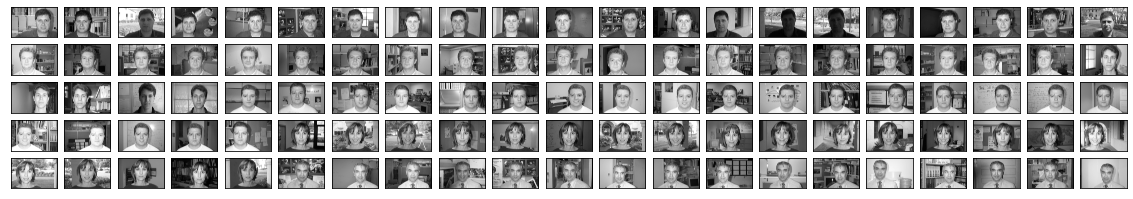

In [6]:
fig = plt.figure(figsize=(20, 20))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(5, 21), 
                 axes_pad=0.1,
                 )

for ax, im in zip(grid, data['images']):
    # Iterating over the grid returns the Axes.
    ax.imshow(im, cmap = 'gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

## II. Face detection


Even though the bounding box coordinates are stored in the <em>CalTechFacesDirs/ImageData.mat</em> file, we'll be computing them from scratch for demonstrative purposes. 

### 1. Detect faces
There are many different face detection algorithms, you can follow the [Learn OpenCV tutorial on Face Detection](https://www.learnopencv.com/face-detection-opencv-dlib-and-deep-learning-c-python/) for some (very coarse) background info for two "conventional" (HAAR-cascade, HOG) CV methods and two Deep Neural Net (Dlib) based (SSD, MMOD) methods.

* Some background on Haar, HOG and MMOD face detectors can be found in this [Guide to Face Detection in Python](https://towardsdatascience.com/a-guide-to-face-detection-in-python-3eab0f6b9fc1). 

* For MMOD specifically, see: [Max-Margin Object Detection by Davis E. King](http://arxiv.org/abs/1502.00046) and the comments at the beginning of the [dnn_mmod_ex.cpp code](https://github.com/davisking/dlib/blob/master/examples/dnn_mmod_ex.cpp).

* For further info on the Single-Shot-Multibox Detector, see [the arXiv publication](https://arxiv.org/abs/1512.02325).

In this assignment we'll be using HAAR, you can find more information about this technique on the [OpenCV website](https://docs.opencv.org/3.4/db/d28/tutorial_cascade_classifier.html).

In [7]:
faceCascade = cv2.CascadeClassifier('./models/haarcascade_frontalface_default.xml')

In [8]:
from sklearn.utils import Bunch
from sklearn.preprocessing import LabelEncoder

feat_data, images, labels = [], [], []


for img, label in zip(data['images'], data['target']):
    faces = faceCascade.detectMultiScale(
        img,
        scaleFactor = 1.2,
        minNeighbors = 9,
        minSize = (30, 30),
        flags = cv2.CASCADE_SCALE_IMAGE
    )

    # iterate faces found in image
    for (x, y, w, h) in faces:
        new_img = img.copy()
        
        # extract ROI
        raw_face = new_img[y:y+h, x:x+w]

        # resize the face to the preferred size
        face = cv2.resize(raw_face, face_size)
        face_flatten = face.flatten()
        
        images.append(np.expand_dims(face, axis=-1)), feat_data.append(face_flatten), labels.append(label)

# encode classes as integer value
label_encoder = LabelEncoder()
targets = label_encoder.fit_transform(labels)

faces = Bunch(data       = np.array(feat_data), 
              images     = np.array(images), 
              labels     = np.array(labels),
              target     = np.array(targets))

### 2. Print statistics of data

In [9]:
# extract number of samples and image dimensions (for later display)
n_samples, h, w, n_channels = faces.images.shape
imshape = (h, w, n_channels)

# count number of individuals
n_classes = faces.target.max() +1

n_features = faces.data.shape[1]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_classes: %d" % n_classes)
print("n_features: %d" % n_features)

Total dataset size:
n_samples: 440
n_classes: 26
n_features: 2209


### 3. Visualise some faces

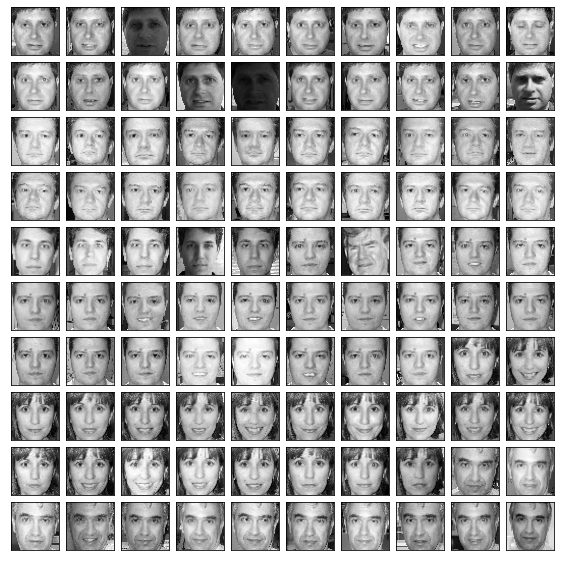

In [10]:
fig = plt.figure(figsize=(10, 10))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(10, 10), 
                 axes_pad=0.1,
                 )

for ax, im in zip(grid, faces['images']):
    # Iterating over the grid returns the Axes.
    ax.imshow(np.mean(im, -1), cmap = 'gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

## III. Feature extraction

Images tend to be large and can differ a lot in lighting, positioning, ... To combat this we'll extract features from each image using 4 different techniques. They all belong to the global/holistic feature representation approaches that map the image to a lower-dimensional subspace through linear and non-linear mapping. 

In [11]:
from enum import Enum
from sklearn.model_selection import train_test_split

# split data for training and testing
holdout_split = lambda X,y: train_test_split(X, y, test_size=.25, shuffle = True, 
                                             stratify = y, random_state = 22)

class FeatureDescriptor(Enum):
    LBP = 1
    PCA = 2
    LDA = 3
    DL = 4

######################################
# select the technique you want to use
DESC = FeatureDescriptor.DL
######################################

# number of PCA/LDA components to retain
global num_components
num_components = 35

### 1. Eigenfaces for face recognition

From [PyImageSearch Gurus Course on Computer Vision](https://www.pyimagesearch.com/pyimagesearch-gurus/) by Adrian Rosebrock:
>In 1971 Goldstein et al. [Identification of human faces](https://ieeexplore.ieee.org/document/1450184) demonstrated that facial characteristics can be manually extracted, quantified and used for face recognition. The question then remained: could this be done in an automatic fashion? 

>It wasn’t until the 1987 paper by Kirby and Sirovich ([A Low-Dimensional Procedure for the Characterization of Human Faces](https://www.researchgate.net/publication/19588504_Low-Dimensional_Procedure_for_the_Characterization_of_Human_Faces)) that we were able to answer this question. This paper is considered to be a seminal work in the history of computer vision — and while other approaches have since been proposed that can outperform Eigenfaces, it’s still important that we take the time to understand and appreciate this algorithm. [Turk and Pentland](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=1&cad=rja&uact=8&ved=2ahUKEwjmvqy6jqfhAhWFZFAKHb74DNgQFjAAegQIABAC&url=http%3A%2F%2Fwww.face-rec.org%2Falgorithms%2Fpca%2Fjcn.pdf&usg=AOvVaw2IlxVps8dldmeA01yQDa_I) built on this idea in the context of face recognition. 

>The Eigenfaces algorithm uses Principal Component Analysis to construct a low-dimensional representation of face images.

>![An example of applying an eigenvalue decomposition to a dataset of faces and extracting the 16 "eigenfaces" with the largest corresponding eigenvalue magnitude.](notebook_images/what_is_fr_eigenfaces.jpg)


>This involves collecting a dataset of faces with multiple face images per person we want to identify — like having multiple training examples of an image class we would want to label in image classification. Given this dataset of face images, presumed to be the same width, height, and ideally — with their eyes and facial structures aligned at the same (x, y)-coordinates, we apply an eigenvalue decomposition of the dataset, keeping the eigenvectors with the largest corresponding eigenvalues.

>Given these eigenvectors, a face can then be represented as a linear combination of what Kirby and Sirovich call eigenfaces.

>Face identification can be performed by computing the Euclidean distance between the eigenface representations and treating the face identification as a k-Nearest Neighbor classification problem — however, we tend to commonly apply more advanced machine learning algorithms to the eigenface representations.

>Last, it’s important to note that the Eigenfaces algorithm is **not-specific to faces** — we can actually apply it to any arbitrary dataset containing objects of the same type that need to be compared, whether that may be bicycles, cans of soup, or ancient Aztec coins. The Eigenfaces algorithm can be modified to accommodate each of these identification tasks.

In [12]:
DESC = FeatureDescriptor.PCA

In [13]:
from sklearn.decomposition import PCA
from scipy.spatial.distance import euclidean

if DESC == FeatureDescriptor.PCA:
    # Compute a PCA (eigenfaces) on the face dataset
    num_components = min(num_components, min(n_samples, n_features))
    print("num_components {n}".format(n=num_components))
    desc = PCA(n_components=num_components, svd_solver='randomized', whiten=True).fit(faces.data)
    X_pca = desc.transform(faces.data)
    embedded_PCA = X_pca
    dist_metric_PCA = euclidean

num_components 35


### 2. Fisherfaces for face recognition

From [Scholarpaedia](http://www.scholarpedia.org/article/Fisherfaces):
> When the goal is classification rather than representation, PCA may not yield the most desirable results. In such cases, one wishes to find a subspace that maps the sample vectors of the same class in a single spot of the feature representation and those of different classes as far apart from each other as possible. The techniques derived to achieve this goal are known as discriminant analysis (DA).
The most known DA is Linear Discriminant Analysis (LDA), which can be derived from an idea suggested by R.A. Fisher in 1936. When LDA is used to find the subspace representation of a set of face images, the resulting basis vectors defining that space are known as [Fisherfaces](http://www.scholarpedia.org/article/Fisherfaces).

![Example of FisherFaces](notebook_images/FisherFaces.jpg)

In [14]:
DESC = FeatureDescriptor.LDA

In [15]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from scipy.spatial.distance import euclidean

if DESC == FeatureDescriptor.LDA:
    num_components = min(num_components, min(n_classes - 1, n_features))
    desc = LinearDiscriminantAnalysis(n_components=num_components).fit(faces.data, faces.target)
    X_lda = desc.fit_transform(faces.data, faces.target)
    embedded_LDA = X_lda
    dist_metric_LDA = euclidean

### 3. LBP for face recognition

Local Binary Patterns, or LBPs for short, are a texture descriptor made popular by the work of Ojala et al. in their 2002 paper, [Multiresolution Grayscale and Rotation Invariant Texture Classification with Local Binary Patterns](https://ieeexplore.ieee.org/document/1017623) (although the concept of LBPs were introduced as early as 1993).

Unlike [Haralick texture features](http://haralick.org/journals/TexturalFeatures.pdf) that compute a global representation of texture based on the [Gray Level Co-occurrence Matrix](https://en.wikipedia.org/wiki/Co-occurrence_matrix), LBPs instead compute a local representation of texture. This local representation is constructed by comparing each pixel with its surrounding neighborhood of pixels. See [PyImageSearch](https://www.pyimagesearch.com/2015/12/07/local-binary-patterns-with-python-opencv/) and [Scikit-Image](http://scikit-image.org/docs/dev/auto_examples/features_detection/plot_local_binary_pattern.html) for further details on LBP.
![LBP](notebook_images/LBP.png)

In [16]:
DESC = FeatureDescriptor.LBP

In [17]:
from localmodules.local_binary_patterns import LBP

def chi_squared (histA, histB, eps=1e-10):
    # compute the chi-squared distance
    d = 0.5 * np.sum(((histA - histB) ** 2) / (histA + histB + eps))
    # return the chi-squared distance
    return d

if DESC == FeatureDescriptor.LBP:
    desc = LBP(numPoints=8, radius=1, grid_x=7, grid_y=7)
    embedded_LBP = desc.describe_list(faces.images[...,0])
    dist_metric_LBP = chi_squared

    

In [18]:
print(dist_metric_LBP)

<function chi_squared at 0x000001B3ACDE5378>


### 4. Deep metric learning
Similar to previous techniques, we can use deep learning to generate an enriched representation of faces that you can use in simple or more complicated classification algorithms. 
Instead of building networks that are trained end-to-end to perform face recognition, we will use deep metric learning. Metric learning based methods learn a projection of the input data on a low-dimensional vector, such that classification in that lower-dimensional space is much easier and can be performed using simple distance metrics. 

In the context of face recognition we can observe the following major Deep Learning based approaches since 2014.

1. The first approach was developed and presented in 2014 by researchers at Facebook and is called [DeepFace](https://www.cs.toronto.edu/~ranzato/publications/taigman_cvpr14.pdf) . The major contributions where a CDNN to classify faces. In addition a 3D/2D alignment procedure is applied prior to classification. 
The CDNN is trained as a classifier on the SFC (Social Face Classification) dataset, which is a very large (4.4 million image of 4000 individuals) dataset. This setting is called supervised.  The challenge is whether this can also be generalizd to other datasets and subjects as well. By training it on the large collection of uncontrolled images, an embedded representation (the vector description prior to the classification layer) can be generated that is, allegedly, generalizable to other face recognition data. One can then use this representation as we have previously done for classical representations. 
By way of demonstration they tested it on the LFW dataset to achieve >0.95% verification accuracy. <br> 

2. The second approach was developed by researchers at Google.  An in-depth presentation of their FaceNet/OpenFace deep CNN's for metric embedding of faces is given by [Martin Krasser et al](http://krasserm.github.io/2018/02/07/deep-face-recognition/). Note that this method was trained on 200 million images of eight million identities. The main methodological point is that these networks are trained using a special loss-function: the triplet loss function. 
>This function is minimized when the distance between an anchor image $x_{ai}$ and a positive image $x_{pi}$ (same identity) in embedding space is smaller than the distance between that anchor image and a negative image $x_{ni}$ (different identity) by at least a margin $\alpha$. Model training aims to learn an embedding f(x) of image x such that the squared L2 distance between all faces of the same identity is small and the distance between a pair of faces from different identities is large. 







There is a very elegant Python implementations available of the FaceNet/OpenFace approach. It is nicely described in [this PyImageSearch tutorial](https://www.pyimagesearch.com/2018/06/18/face-recognition-with-opencv-python-and-deep-learning/). It explicitly includes the Dlib package with the [face_recognition modules](https://face-recognition.readthedocs.io/en/latest/index.html) for face detection and recognition. Especially the latter package provides a very convenient interface. 

From the [Dlib face_recognition.py](https://github.com/davisking/dlib/blob/master/python_examples/face_recognition.py) code, we get an application view of the embedding:

> This example shows how to use dlib's face recognition tool.  This tool maps an image of a human face to a 128 dimensional vector space where images of the same person are near to each other and images from different people are far apart.  Therefore, you can perform face recognition by mapping faces to the 128D space and then checking if their Euclidean distance is small enough. 

> When using a distance threshold of 0.6, the dlib model obtains an accuracy of 99.38% on the standard LFW face recognition benchmark, which is comparable to other state-of-the-art methods for face recognition as of February 2017. This accuracy means that, when presented with a pair of face images, the tool will correctly identify if the pair belongs to the same person or is from different people 99.38% of the time.

In the [DeepFace](https://www.cs.toronto.edu/~ranzato/publications/taigman_cvpr14.pdf) paper they also tested a [siamese network](https://en.wikipedia.org/wiki/Siamese_network) DNN architecture for generating embedded vector representations.  This consists of two copies of the same CNN (sharing their weights) that are applied to pairs of images. During training the distance between the embedded representations of the same individual is minimized, and the distances between embedded representations of different individuals is maximized. In the mean time, this work was extended, steadily increasing the performance. Siamese networks are an example of *One-shot Learning* where you tyically have very few samples per object or dynamically changing number of objects/subjects. While [this link](https://towardsdatascience.com/one-shot-learning-with-siamese-networks-using-keras-17f34e75bb3d) tests it on a non-face recognition task, it can be applied to face recognition as well.

The localmodules.siamese file contains the description of a shallow CNN model that is trained with [contrastive loss](https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf).
This subnetwork is copied twice and the output of both siamese copies are then passed onto a vector euclidean distance (ED) calculation layer. The network gets as input pairs of imposter or genuine images with the associated label (genuine = 0, imposter = 1). You can make use of the output of the network or the output before the ED layer (embedded) in your validation.

Note: this part on Siamese networks is adapted from [Packt tutorial](https://hub.packtpub.com/face-recognition-using-siamese-networks-tutorial/), which seems to be a re-implementation from  [this Packt book on Neural Network Projects with Python](https://subscription.packtpub.com/book/big_data_and_business_intelligence/9781789138900)). See also [this Hackernoon tutorial](https://hackernoon.com/one-shot-learning-with-siamese-networks-in-pytorch-8ddaab10340e).

Note: you can change the CNN at your will, but beware that it might take additional training time.

In [19]:
# If you encounter problem importing the siamese model, consider using Google Colab.
import localmodules.siamese as siamese


encoder, model = siamese.create_siamese_model(imshape)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 47, 47, 1)]  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 47, 47, 1)]  0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 128)          894400      input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           sequential[0][0]             

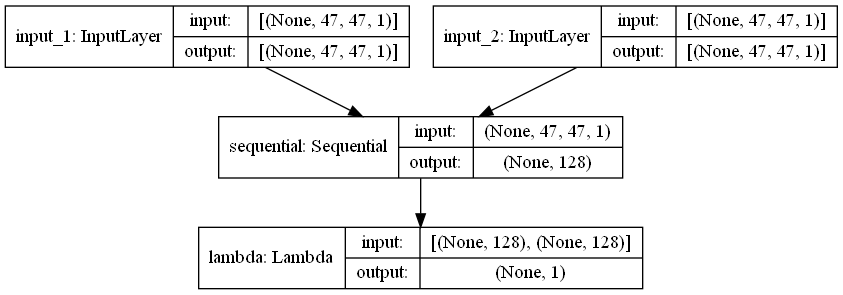

In [20]:
# To visualize your model structure:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes = True, show_layer_names = True)

Depending on the complexity of the Siamese network this might take a while. You can also change the number of epochs to improve the training (with the risk of overfitting). You will notice that a small number (<10) of epochs already gets you a decent performance.

In [21]:
DESC = FeatureDescriptor.DL

In [22]:
import localmodules.siamese as siamese
from tensorflow.keras.optimizers import RMSprop, Adam

from scipy.spatial.distance import euclidean
from sklearn.metrics import accuracy_score

if DESC == FeatureDescriptor.DL:
    x_train, x_test, y_train, y_test = holdout_split(*siamese.get_siamese_paired_data(faces.images, faces.target))
    rms = Adam()
    model.compile(
        loss=siamese.contrastive_loss, 
        optimizer=rms, 
        metrics = [siamese.accuracy],
        run_eagerly=True)

    epochs = 10
    model.fit([x_train[:, 0], x_train[:, 1]], y_train, 
              validation_split=0.2,
              batch_size=32, verbose=2, epochs=epochs)
    
    test_scores = model.predict([x_test[:, 0], x_test[:, 1]])
    test_acc = accuracy_score(y_test, test_scores > 0.5)
    print("Accuracy on the test set: {}".format(test_acc))
    embedded_DL = encoder(faces.images.astype(np.float32)).numpy()
    dist_metric_DL = euclidean

Epoch 1/10
38/38 - 2s - loss: 0.0907 - accuracy: 0.7442 - val_loss: 0.0522 - val_accuracy: 0.8802
Epoch 2/10
38/38 - 1s - loss: 0.0360 - accuracy: 0.9424 - val_loss: 0.0400 - val_accuracy: 0.9229
Epoch 3/10
38/38 - 1s - loss: 0.0235 - accuracy: 0.9712 - val_loss: 0.0279 - val_accuracy: 0.9604
Epoch 4/10
38/38 - 1s - loss: 0.0165 - accuracy: 0.9794 - val_loss: 0.0255 - val_accuracy: 0.9542
Epoch 5/10
38/38 - 1s - loss: 0.0133 - accuracy: 0.9893 - val_loss: 0.0236 - val_accuracy: 0.9750
Epoch 6/10
38/38 - 1s - loss: 0.0103 - accuracy: 0.9967 - val_loss: 0.0200 - val_accuracy: 0.9760
Epoch 7/10
38/38 - 1s - loss: 0.0081 - accuracy: 1.0000 - val_loss: 0.0170 - val_accuracy: 0.9823
Epoch 8/10
38/38 - 1s - loss: 0.0057 - accuracy: 1.0000 - val_loss: 0.0147 - val_accuracy: 0.9885
Epoch 9/10
38/38 - 1s - loss: 0.0047 - accuracy: 1.0000 - val_loss: 0.0139 - val_accuracy: 0.9885
Epoch 10/10
38/38 - 1s - loss: 0.0039 - accuracy: 1.0000 - val_loss: 0.0131 - val_accuracy: 0.9917
Accuracy on the tes

## IV. Distance-based and classification-based scoring

Biometrics is based on generating pairwise matching scores. In it's simplest form, the score is computed based on the distance metrics (distance-based scoring). E.g. a simple pairwise comparision (L2-distance, e.g.) can be used. 

* In verification mode one compares this matching score to a decision threshold in a 1-to-1 setting.
* In identifcation mode one uses this matching score to rank the templates in the database and, possibly, thresholding it as well in a 1-to-N setting
 

On the other hand, some classification algorithms provide us with the classification scores (or probabilities), which are related to the likelihood that an image belongs to each subject in the dataset. These classification scores can be seen as an advanced classification-based matching score. 

* In verification mode one compares the soft scores (or probabilities) of the classification with a threshold to verify whether the person is who he claims to be.
* In identifcation mode one sorts the soft scores to propose the most similar people in the dataset.

To implement a classification-based system (optional task 3), the following steps are expected:
1. For each person in the dataset leave one image out (E.g. the first image in the dataset) for the testset. This means the size of the test set equals the number of individuals in the data (=n).
2. Run the classifier of your choice and generate the classification probabilities for each test image.
3. Build your n by n similarity matrix, in which each row corresponds to a test image and each column corresponds to an individual in the dataset.
4. Calculate the evaluation metrics (E.g. ROC) based on the obtained similarity matrix to test your system in a verification or identification scenario.

<div class="alert alert-block alert-success">
<b>Q1: </b> Compute distance-based pair-wise matching scores.
</div>

Given the function <em>dist_metric</em> and the vector representations in variable <em>embedded</em>, compute the pairwise distances. Do this for PCA, LDA, LBP and a DL facial representations, given the code above.

In [23]:
"""
Based on dist_metric, we will compute the parwise distances 
between the different embedding (stored in variable 'embedded')

To construct the table, we use a code we have defined in assignment2
We have N=440 images in the dataset
So, the similarity matrix will be of size NxN (we will compare each image with each image)
"""


#based on function defined in assignment 2
def constructSimilarityTable(embedded, labels, dist_func):
    """
    ----------------------
    Input
    ----------------------
    - dist_func is the function that computes the distance between two images
    - embedded is the embedding of the image, e.g. shape is (440,128) corresponding to embedding of size 128 for 440 image
    - target is the class of the image (in this example we have 26 identities, so target can take value from 0 to 25)
    -----------------------
     Output
    -----------------------
    - The similarity table
    
    
    """
    table=[]
    #for each embedding:
    for i,embedded_compared in enumerate(embedded):
        table_column = []
        #we compare it to all other embedding
        for j,embedded_to_compare in enumerate(embedded):
            distance = dist_func(embedded_compared, embedded_to_compare)
            table_column.append(distance)
        table.append([table_column,i])
    df = pd.DataFrame(table, columns=['score', 'id'])
    df=pd.DataFrame(df['score'].to_list(), columns=[*range(0, 440, 1)])

    return df


#### For PCA

In [24]:
sim_tb_PCA = constructSimilarityTable(embedded_PCA,labels, dist_metric_PCA)
sim_tb_PCA

,0,1,2,3,4,5,6,7,8,9,...,430,431,432,433,434,435,436,437,438,439
0,0.000000,5.326238,6.824931,3.456548,3.675690,4.698031,6.268797,6.685367,5.864693,6.181352,...,9.252982,7.660241,6.765265,6.110967,6.403124,5.895205,4.870635,6.252789,7.317506,6.402103
1,5.326238,0.000000,6.259944,4.549099,4.821327,6.091789,6.010067,6.259768,4.615755,6.652761,...,9.981748,6.913555,5.968180,5.942784,6.101233,6.851011,6.402850,5.859980,6.532118,5.410630
2,6.824931,6.259944,0.000000,5.895513,7.515085,7.117609,6.422150,8.227854,5.550528,8.924827,...,10.321280,7.504487,6.749868,7.505474,6.837020,8.717849,7.869358,7.460347,7.318959,7.016130
3,3.456548,4.549099,5.895513,0.000000,4.594826,5.831501,6.097180,5.810513,5.452353,5.896161,...,9.913512,6.940223,6.491314,5.902326,5.986334,6.106910,5.467141,5.985174,6.790817,5.839911
4,3.675690,4.821327,7.515085,4.594826,0.000000,4.007751,6.104019,6.072960,5.364445,5.594937,...,9.213569,7.766217,7.192743,6.651899,7.132792,6.296194,5.376810,6.369937,7.431544,6.459042
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
435,5.895205,6.851011,8.717849,6.106910,6.296194,6.312294,8.107491,8.159582,7.957477,7.908231,...,9.413783,7.004446,6.471819,6.157692,5.399228,0.000000,4.496307,6.201588,5.812129,5.768649
436,4.870635,6.402850,7.869358,5.467141,5.376810,5.764346,6.996561,7.093906,7.082731,6.399596,...,9.434619,6.281820,5.812535,5.814753,5.000857,4.496307,0.000000,5.203574,5.282635,4.766856
437,6.252789,5.859980,7.460347,5.985174,6.369937,6.594036,7.039194,7.595967,7.034032,7.554411,...,10.837140,5.572733,3.690152,3.231191,3.267918,6.201588,5.203574,0.000000,3.841222,4.066357
438,7.317506,6.532118,7.318959,6.790817,7.431544,7.202909,6.625299,8.354801,7.275380,8.208028,...,10.987985,5.208572,4.497946,4.140039,3.687392,5.812129,5.282635,3.841222,0.000000,4.428208


As we can see, we have **0 values in the diagonal of the matrix**. This is normal because in the diagonal of the matrix, we compute the distance between the same image ! However, we see that the similarity between image 0 and image 1 is 5.397361, even if these images are from the same person (label[0] = label[1])

#### For LDA

In [25]:
sim_tb_LDA = constructSimilarityTable(embedded_LDA,labels, dist_metric_LDA)
sim_tb_LDA


,0,1,2,3,4,5,6,7,8,9,...,430,431,432,433,434,435,436,437,438,439
0,0.000000,6.255456,9.828133,7.391354,6.824139,5.418200,6.183437,6.307149,6.378050,5.643873,...,16.510813,18.895998,15.842347,17.212987,18.279026,17.034364,14.124331,18.768981,16.740232,19.382462
1,6.255456,0.000000,8.985383,4.425066,5.524647,5.210535,5.755421,5.104526,4.844360,4.913737,...,15.906479,18.167572,15.282475,16.933665,17.564945,16.543141,14.130830,18.172530,15.901287,18.289974
2,9.828133,8.985383,0.000000,9.483260,10.486247,8.667542,9.484435,8.995129,9.246571,9.375018,...,14.958877,17.331718,14.474956,16.621915,16.992559,15.734653,11.930808,17.111925,15.270795,17.731951
3,7.391354,4.425066,9.483260,0.000000,6.271503,6.088876,6.322348,6.301018,6.119460,7.219432,...,15.884795,18.201147,14.881225,17.098349,17.620866,16.141986,13.668429,17.912185,15.547222,18.315041
4,6.824139,5.524647,10.486247,6.271503,0.000000,4.540980,5.088987,4.072870,5.141810,5.974761,...,17.268362,18.681183,16.661972,17.987343,18.973098,17.460561,14.989608,19.512984,17.197226,19.585711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
435,17.034364,16.543141,15.734653,16.141986,17.460561,15.537316,18.233171,16.097147,17.496843,18.073984,...,5.095300,6.724544,8.458871,5.454388,4.668361,0.000000,9.379508,4.931939,5.521539,6.736131
436,14.124331,14.130830,11.930808,13.668429,14.989608,12.578406,15.177942,14.476344,14.393396,15.554593,...,9.825242,11.867568,9.506151,10.279022,10.934418,9.379508,0.000000,9.872033,9.223203,10.646684
437,18.768981,18.172530,17.111925,17.912185,19.512984,17.285443,20.081557,18.187541,19.302855,19.802126,...,5.638863,7.756094,9.271042,4.559821,5.204608,4.931939,9.872033,0.000000,6.148688,6.811352
438,16.740232,15.901287,15.270795,15.547222,17.197226,14.889446,17.683232,15.692043,16.936276,17.980942,...,5.129135,6.483591,7.861088,6.968430,5.157978,5.521539,9.223203,6.148688,0.000000,5.784223


#### For LBP

In [26]:
sim_tb_LBP = constructSimilarityTable(embedded_LBP,labels, dist_metric_LBP)
sim_tb_LBP


,0,1,2,3,4,5,6,7,8,9,...,430,431,432,433,434,435,436,437,438,439
0,0.000000,4.817430,6.989416,5.101078,5.110625,4.936796,5.211555,5.864193,5.599304,5.413731,...,8.115463,6.416538,6.371145,6.478756,6.439952,6.028481,6.927112,6.505435,6.073323,6.118790
1,4.817430,0.000000,7.213450,5.168230,5.052563,5.681641,5.208505,6.647274,5.295334,5.669356,...,8.152896,6.459295,6.407573,7.027135,6.680720,6.596349,8.381217,6.600115,6.605394,6.651565
2,6.989416,7.213450,0.000000,6.880620,7.703194,7.436022,6.368623,6.450984,6.734145,6.983511,...,7.503994,7.956236,7.897338,8.640776,7.543414,8.382630,10.253674,8.761857,7.983415,7.615998
3,5.101078,5.168230,6.880620,0.000000,5.177446,5.786241,5.106932,5.827038,5.092170,5.332956,...,7.895439,7.125934,6.782946,6.472967,6.346970,6.454643,8.303626,6.977874,6.763724,6.300348
4,5.110625,5.052563,7.703194,5.177446,0.000000,6.119033,5.012413,6.240924,5.147160,5.640808,...,7.649914,6.878781,6.697201,6.212489,6.897337,6.574191,8.657071,6.816313,5.943087,6.475599
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
435,6.028481,6.596349,8.382630,6.454643,6.574191,6.448187,6.641224,7.728991,7.022798,7.100421,...,8.575302,6.322848,6.987147,5.950269,5.982093,0.000000,6.238080,6.524985,6.171962,5.501838
436,6.927112,8.381217,10.253674,8.303626,8.657071,6.809623,8.527996,8.876028,8.695783,8.196391,...,10.779791,7.543204,7.640138,8.008625,7.011480,6.238080,0.000000,7.254715,7.789167,7.172513
437,6.505435,6.600115,8.761857,6.977874,6.816313,6.596125,6.495154,7.580006,6.865341,6.912695,...,8.732686,5.742098,5.312004,5.755967,5.520997,6.524985,7.254715,0.000000,5.198986,5.262652
438,6.073323,6.605394,7.983415,6.763724,5.943087,6.833129,6.669967,7.385812,6.829665,6.221064,...,7.894534,4.922883,5.313902,5.036184,5.874405,6.171962,7.789167,5.198986,0.000000,5.318515


#### For DL

In [27]:
sim_tb_DL = constructSimilarityTable(embedded_DL,labels, dist_metric_DL)
sim_tb_DL

,0,1,2,3,4,5,6,7,8,9,...,430,431,432,433,434,435,436,437,438,439
0,0.000000,32.946140,74.577431,14.185711,37.383839,18.064711,14.819017,37.763512,16.517376,33.337025,...,147.273270,146.454620,160.205734,154.520569,153.926376,167.780182,153.597397,177.366440,149.157806,152.740982
1,32.946140,0.000000,65.828796,33.475800,64.643005,35.199051,41.453842,60.624378,29.564634,44.938259,...,159.643829,156.615570,169.479416,165.156616,165.233948,179.392258,165.660339,187.456650,159.056900,164.409683
2,74.577431,65.828796,0.000000,80.392593,104.130272,80.264526,77.032677,95.251137,72.182297,72.675949,...,126.031937,115.474297,123.992104,126.340286,128.411224,139.725342,122.645279,143.344193,120.349373,126.488701
3,14.185711,33.475800,80.392593,0.000000,37.858814,15.074960,21.637714,35.107174,18.058359,28.877790,...,152.472168,153.623825,167.740341,161.135941,159.590790,174.518524,161.622543,184.468994,155.378204,159.114609
4,37.383839,64.643005,104.130272,37.858814,0.000000,38.699455,32.108662,40.460007,47.817120,49.123779,...,155.507416,162.802017,176.130478,167.082687,166.680908,179.206619,167.281448,190.243835,165.643814,165.227219
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
435,167.780182,179.392258,139.725342,174.518524,179.206619,175.875839,162.919174,166.830124,170.746811,161.111343,...,48.130531,37.882881,30.326408,21.974785,28.449347,0.000000,32.740749,20.250427,43.896317,21.312275
436,153.597397,165.660339,122.645279,161.622543,167.281448,162.426361,149.398087,156.191360,156.459579,150.413391,...,61.087025,28.723652,17.578228,37.045101,43.349941,32.740749,0.000000,33.768688,42.637531,31.676388
437,177.366440,187.456650,143.344193,184.468994,190.243835,185.587326,172.796600,179.006973,179.713715,171.749557,...,61.670204,42.303902,26.941317,36.039150,44.059219,20.250427,33.768688,0.000000,51.686134,35.694859
438,149.157806,159.056900,120.349373,155.378204,165.643814,155.982559,146.303329,147.197342,149.861954,142.287827,...,61.532307,22.276052,39.460934,37.539654,32.768986,43.896317,42.637531,51.686134,0.000000,36.543049


## V. Evaluation

In this section you can re-use the code you developed for validation in the previous assignments, and in particular assignment 1. 

### 1. Validation as verification system

<div class="alert alert-block alert-success">
<b>Q2: </b> Compute F1 and accuracy scores for variable (and optimal) thresholds
</div>

* Calculate and plot F1 and accuracy scores for a range (min, max) of thresholds.
* Determine some optimal threshold (look up in classification literature). Justify your answer.

First, we need to **convert the similarity values to score** (normalize between 0 and 1 etc)

In [28]:
#min-max normalization
def normalize(df):
    df=(df-df.min())/(df.max()-df.min())
    
    return df

In [29]:
sim_tb_PCA_normalized = normalize(sim_tb_PCA)
sim_tb_LDA_normalized = normalize(sim_tb_LDA)
sim_tb_LBP_normalized = normalize(sim_tb_LBP)
sim_tb_DL_normalized = normalize(sim_tb_DL)


In [30]:
sim_tb_PCA_normalized

,0,1,2,3,4,5,6,7,8,9,...,430,431,432,433,434,435,436,437,438,439
0,0.000000,0.389252,0.529846,0.244477,0.284746,0.377161,0.457031,0.487412,0.427376,0.461066,...,0.601052,0.568016,0.491894,0.472836,0.482509,0.441939,0.385416,0.464403,0.553135,0.476207
1,0.406655,0.000000,0.485984,0.321752,0.373496,0.489053,0.438168,0.456382,0.336362,0.496229,...,0.648391,0.512648,0.433939,0.459823,0.459760,0.513592,0.506661,0.435228,0.493767,0.402459
2,0.521079,0.457489,0.000000,0.416982,0.582174,0.571406,0.468212,0.599870,0.404482,0.665702,...,0.670446,0.556467,0.490774,0.580736,0.515205,0.653541,0.622707,0.554090,0.553244,0.521881
3,0.263905,0.332457,0.457692,0.000000,0.355949,0.468157,0.444520,0.423628,0.397327,0.439794,...,0.643958,0.514626,0.471975,0.456693,0.451102,0.457810,0.432618,0.444527,0.513322,0.434390
4,0.280636,0.352352,0.583425,0.324986,0.000000,0.321745,0.445018,0.442763,0.390921,0.417326,...,0.598492,0.575874,0.522975,0.514691,0.537493,0.472000,0.425470,0.473104,0.561755,0.480443
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
435,0.450095,0.500685,0.676801,0.431934,0.487750,0.506755,0.591083,0.594893,0.579882,0.589874,...,0.611497,0.519388,0.470558,0.476451,0.406860,0.000000,0.355795,0.460600,0.439342,0.429089
436,0.371870,0.467933,0.610929,0.386684,0.416527,0.462765,0.510090,0.517197,0.516137,0.477345,...,0.612851,0.465804,0.422622,0.449917,0.376841,0.337070,0.000000,0.386476,0.399317,0.354573
437,0.477396,0.428259,0.579176,0.423324,0.493462,0.529373,0.513198,0.553801,0.512588,0.563483,...,0.703955,0.413225,0.268306,0.250013,0.246255,0.464907,0.411762,0.000000,0.290360,0.302468
438,0.558686,0.477380,0.568199,0.480306,0.575702,0.578254,0.483022,0.609125,0.530176,0.612236,...,0.713754,0.386222,0.327040,0.320336,0.277864,0.435711,0.418018,0.285293,0.000000,0.329383


In a verification framework, we need to classify the input as **Impostor (False) or Genuine (True)**. If we look at the similariy matrix above for example, we see that image 4  (corresponding to targets[4]=0) and image 438 (corresponding to targets[438]=25) have a similarity score of 0.579152. Therefore, if we fix the threshold to 0.5, they will be considered as the same identify, which will result in a False identification !



In [31]:
print(targets[438],targets[4])

25 0


What we need now is to compute the **scores** 

In [32]:
from itertools import product


def NormalizeData(data):
    return (np.max(data) - data) / (np.max(data) - np.min(data))
    
def construct_similarity_mat(embedded, labels, dist_func):
    data = []
    n_samples = embedded.shape[0]
    for i,j in product(range(n_samples), range(n_samples)):
        if i != j:
            data.append([labels[i], labels[j],dist_func(embedded[i], embedded[j])])
    return pd.DataFrame(data, columns=['s1', 's2', 'd'])


def construct_scores(face_df):
    normalized_face_vector = NormalizeData(face_df['d'].values) 
    normalized_face_df = face_df.copy()
    normalized_face_df['d'] = normalized_face_vector
    face_mat = normalized_face_df.pivot_table(index='s1', columns='s2',values='d',aggfunc = np.average)
    genuine_df = normalized_face_df[normalized_face_df.apply(lambda x: x.s1 == x.s2, axis=1)]
    genuine_df = genuine_df.drop(genuine_df[(genuine_df.d).astype(int)==1].index)
    genuine_df = genuine_df.reset_index()
    impostor_df = normalized_face_df[normalized_face_df.apply(lambda x: x.s1 != x.s2, axis=1)]
    genuine_scores = genuine_df['d'].values
    impostor_scores = impostor_df['d'].values
    total_scores = np.concatenate([genuine_scores, impostor_scores])
    genuine_id = np.concatenate([np.ones_like(genuine_scores), np.zeros_like(impostor_scores)])
    return total_scores, genuine_id, genuine_scores, impostor_scores


In [33]:
face_df_PCA = construct_similarity_mat(embedded_PCA, targets, dist_metric_PCA)
total_scores_PCA, genuine_id_PCA, genuine_scores_PCA, impostor_scores_PCA = construct_scores(face_df_PCA)

face_df_LDA = construct_similarity_mat(embedded_LDA, targets, dist_metric_LDA)
total_scores_LDA, genuine_id_LDA, genuine_scores_LDA, impostor_scores_LDA = construct_scores(face_df_LDA)

face_df_LBP = construct_similarity_mat(embedded_LBP, targets, dist_metric_LBP)
total_scores_LBP, genuine_id_LBP, genuine_scores_LBP, impostor_scores_LBP = construct_scores(face_df_LBP)

face_df_DL = construct_similarity_mat(embedded_DL, targets, dist_metric_DL)
total_scores_DL, genuine_id_DL, genuine_scores_DL, impostor_scores_DL = construct_scores(face_df_DL)

In [34]:
from sklearn.metrics import f1_score


def compute_f1(total_scores, genuine_id, thresholds):

    f1_scores = []

    for thresh in thresholds: 
        predicted_scores = np.array(total_scores > thresh).astype('int')
        f1_scores.append(f1_score(genuine_id, predicted_scores))
    return f1_scores
        
def compute_accuracies(total_scores, genuine_id, thresholds):

    accuracies= []
    for thresh in thresholds: 
        predicted_scores = np.array(total_scores > thresh).astype('int')
        accuracies.append(accuracy_score(genuine_id, predicted_scores))
    return accuracies
    
threshold_values = np.linspace(0, 1, 50)

f1_scores_PCA = compute_f1(total_scores_PCA, genuine_id_PCA, threshold_values)
f1_scores_LDA = compute_f1(total_scores_LDA, genuine_id_LDA, threshold_values)
f1_scores_LBP = compute_f1(total_scores_LBP, genuine_id_LBP, threshold_values)
f1_scores_DL = compute_f1(total_scores_DL, genuine_id_DL, threshold_values)

accuracies_PCA = compute_accuracies(total_scores_PCA, genuine_id_PCA, threshold_values)
accuracies_LDA = compute_accuracies(total_scores_LDA, genuine_id_LDA, threshold_values)
accuracies_LBP = compute_accuracies(total_scores_LBP, genuine_id_LBP, threshold_values)
accuracies_DL = compute_accuracies(total_scores_DL, genuine_id_DL, threshold_values)

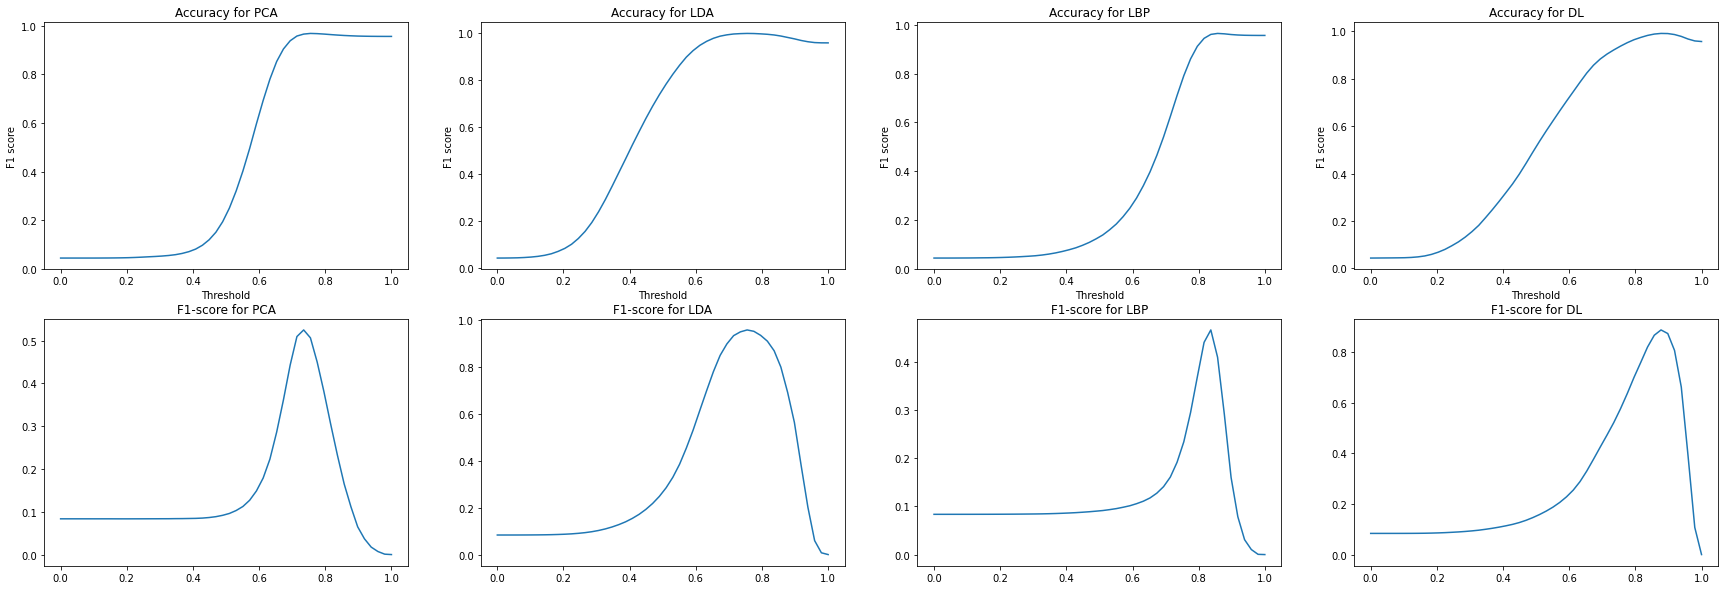

In [35]:
fig, ax = plt.subplots(2,4, figsize=(30,10)) 

accuracies = [accuracies_PCA,accuracies_LDA,accuracies_LBP,accuracies_DL]
f1_scores = [f1_scores_PCA,f1_scores_LDA,f1_scores_LBP,f1_scores_DL]
method = ["PCA", "LDA", "LBP", "DL"]

for i in range(0,len(method)):
    ax[0,i].plot(threshold_values,accuracies[i])
    ax[0,i].set_title("Accuracy for " + method[i])
    ax[0,i].set_xlabel("Threshold")
    ax[0,i].set_ylabel("Accuracy")
    
    ax[1,i].plot(threshold_values,f1_scores[i])
    ax[1,i].set_title("F1-score for " + method[i])
    ax[0,i].set_xlabel("Threshold")
    ax[0,i].set_ylabel("F1 score")



<div class="alert alert-block alert-success">
<b>Q3: </b> Plot genuine and impostor scores
</div>
When comparing the different feature extractions/facial representations, discuss the difference in the overlap between genuine and imposter scores.

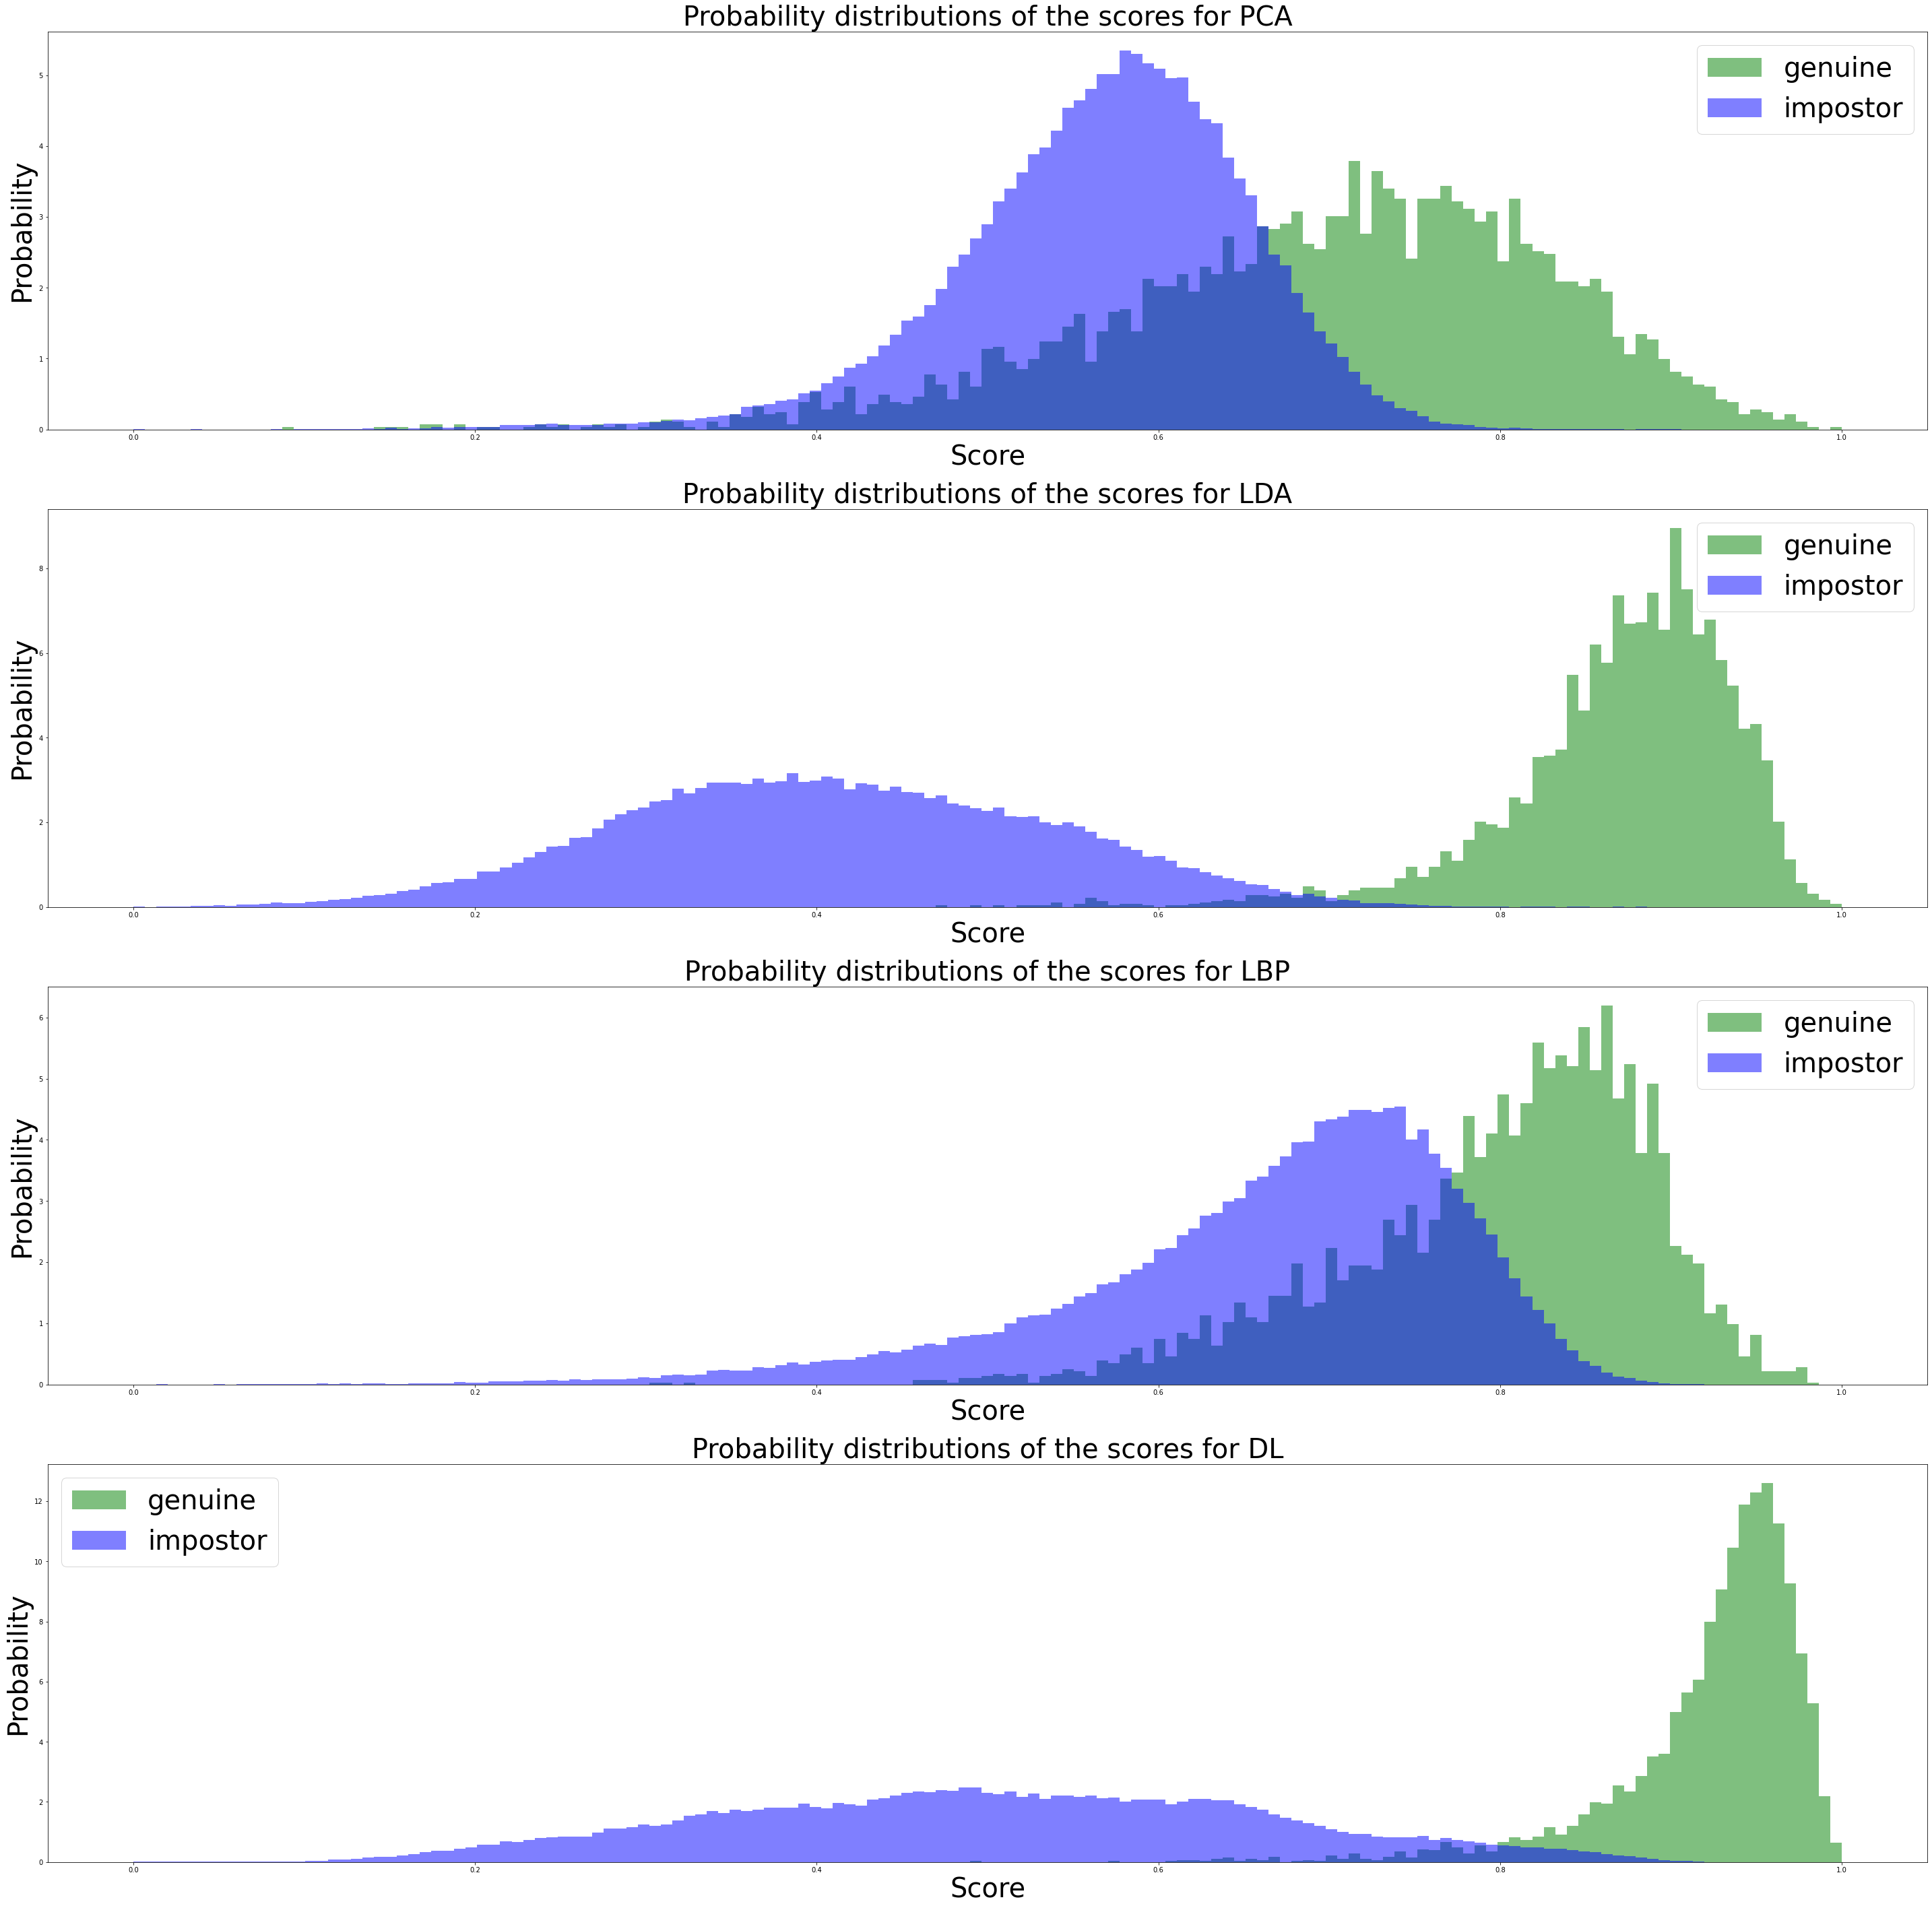

In [36]:
fig, ax = plt.subplots(4,1, figsize=(50,50)) 
bins = np.linspace(0, 1, 150)

method = ["PCA", "LDA", "LBP", "DL"]
genuine_scores = [genuine_scores_PCA,genuine_scores_LDA,genuine_scores_LBP,genuine_scores_DL]
impostor_scores = [impostor_scores_PCA,impostor_scores_LDA,impostor_scores_LBP,impostor_scores_DL]

for i in range(0,len(method)):
    ax[i].hist(genuine_scores[i],color='g',density=True,alpha=0.5,bins = bins,label = "genuine") 
    ax[i].hist(impostor_scores[i], color='b',density=True,alpha=0.5,bins = bins,label = "impostor") 
    ax[i].set_title("Probability distributions of the scores for " +method[i] , fontsize=40)
    ax[i].legend(fontsize=40)
    ax[i].set_xlabel('Score', fontsize=40)
    ax[i].set_ylabel('Probability', fontsize=40)


#### Optimal thresholds

We will look at optimal threshold for the f1-score

In [37]:
def optimal_threshold(f1_scores):
    optimal_thresholds = []
    top_f1 = []
    for f1_score in f1_scores:
        max_f1 = max(f1_score)
        max_index = f1_score.index(max_f1)
        top_f1.append(max_f1)
        optimal_thresholds.append(threshold_values[max_index])
    return top_f1,optimal_thresholds

top_f1,optimal_thresholds = optimal_threshold([f1_scores_PCA,f1_scores_LDA,f1_scores_LBP,f1_scores_DL])

In [38]:
#to print beautiful tables
from beautifultable import BeautifulTable

table = BeautifulTable()
table.rows.append([optimal_thresholds[0], top_f1[0]])
table.rows.append([optimal_thresholds[1], top_f1[1]])
table.rows.append([optimal_thresholds[2], top_f1[2]])
table.rows.append([optimal_thresholds[3], top_f1[3]])
table.rows.header = ["PCA", "LDA", "LBP", "DL"]
table.columns.header = ["Optimal Threshold", "Maximum f1-score"]
print(table)



+-----+-------------------+------------------+
|     | Optimal Threshold | Maximum f1-score |
+-----+-------------------+------------------+
| PCA |       0.735       |      0.525       |
+-----+-------------------+------------------+
| LDA |       0.755       |       0.96       |
+-----+-------------------+------------------+
| LBP |       0.837       |      0.466       |
+-----+-------------------+------------------+
| DL  |       0.878       |      0.887       |
+-----+-------------------+------------------+


<div class="alert alert-block alert-success">
<b>Q4: </b> Perform a full-on verification assessment based on the scores obtained. Interpret the results.
</div>

Hint: Calculate and plot the equal error rate. Plot the precision-recall curve and compute AUC and average precision. Interpret the results e.g. by explaining what aspect of the system performance is explored by each metric.

#### ROC and AUC

In [39]:
from sklearn.metrics import roc_curve 

fpr_PCA, tpr_PCA, thresholds_PCA = roc_curve(genuine_id_PCA, total_scores_PCA, pos_label=1)
fpr_LDA, tpr_LDA, thresholds_LDA = roc_curve(genuine_id_LDA, total_scores_LDA, pos_label=1)
fpr_LBP, tpr_LBP, thresholds_LBP = roc_curve(genuine_id_LBP, total_scores_LBP, pos_label=1)
fpr_DL, tpr_DL, thresholds_DL = roc_curve(genuine_id_DL, total_scores_DL, pos_label=1)


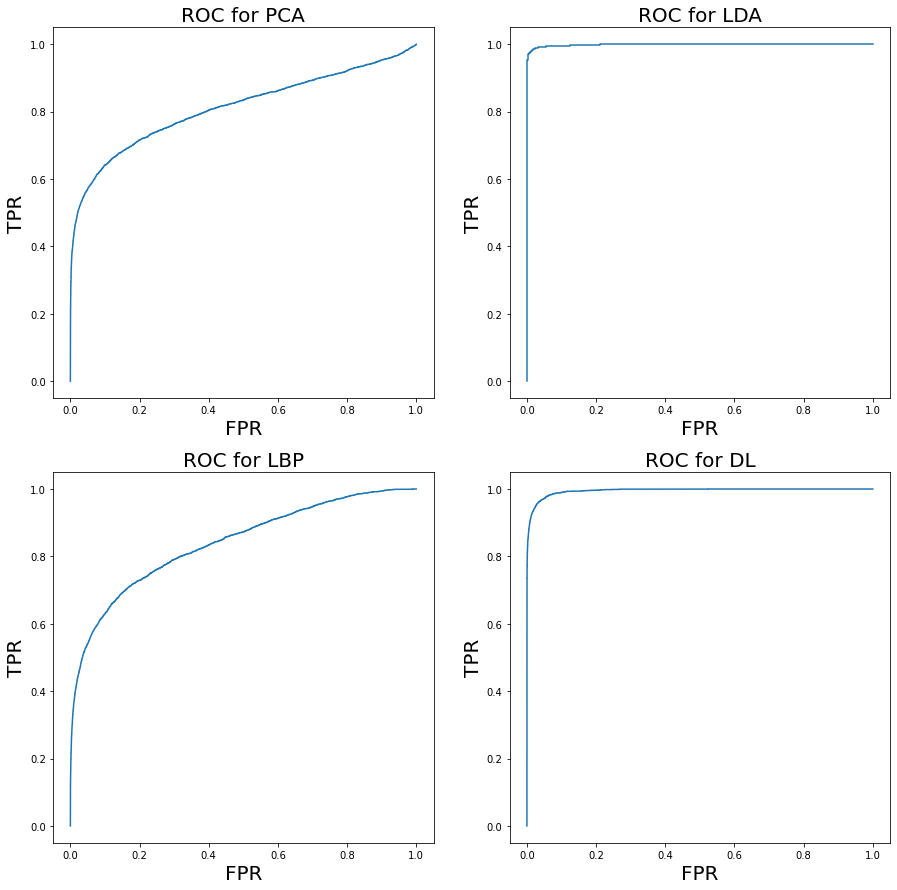

In [40]:
fig, ax = plt.subplots(2,2, figsize=(15,15)) 
bins = np.linspace(0, 1, 150)

method = ["PCA", "LDA", "LBP", "DL"]
fpr = [fpr_PCA,fpr_LDA,fpr_LBP,fpr_DL]
tpr = [tpr_PCA,tpr_LDA,tpr_LBP,tpr_DL]


for i, ax in enumerate(fig.axes):
    ax.plot(fpr[i],tpr[i]) 
    ax.set_title("ROC for " +method[i] , fontsize=20)
    ax.set_xlabel('FPR', fontsize=20)
    ax.set_ylabel('TPR', fontsize=20)

In [41]:
from sklearn import metrics

"""Calculate the ROC AUC."""
#the function metrics.auc(y_true, y_score) allows us to compute the ROC AUC, based on the fpr vector and the tpr vector 

method = ["PCA", "LDA", "LBP", "DL"]
genuine_ids=[genuine_id_PCA,genuine_id_LDA,genuine_id_LBP,genuine_id_DL]
total_scores=[total_scores_PCA,total_scores_LDA,total_scores_LBP,total_scores_DL]
ROC_AUC =[]

for i in range(len(method)):
    ROC_AUC.append(metrics.roc_auc_score(genuine_ids[i], total_scores[i]))

    
table = BeautifulTable()
table.rows.append([ROC_AUC[0]])
table.rows.append([ROC_AUC[1]])
table.rows.append([ROC_AUC[2]])
table.rows.append([ROC_AUC[3]])

table.rows.header = method
table.columns.header = ["ROC AUC"]
print(table)

+-----+---------+
|     | ROC AUC |
+-----+---------+
| PCA |  0.811  |
+-----+---------+
| LDA |  0.998  |
+-----+---------+
| LBP |  0.84   |
+-----+---------+
| DL  |  0.995  |
+-----+---------+


#### Equal Error Rate

In [42]:
"""Calculate (by approximation) the EER and plot it on the FAR-FRR curve."""

#EER is at the threshold where FAR (False acceptance rate, or FPR) = FRR (false rejection rate, or FNR)

def compute_EER(fpr,tpr,thresholds):
    fnr = 1 - tpr
    df_to_find_EER = pd.DataFrame([fpr,fnr,thresholds],index = ["fpr","fnr","thresholds"]).transpose()
    #select row where fpr_li is the closest to fnr_li
    EER_row = df_to_find_EER.iloc[(df_to_find_EER["fpr"]-df_to_find_EER["fnr"]).abs().argsort()[:1]]
    
    return EER_row

EER_row_PCA = compute_EER(fpr_PCA,tpr_PCA,thresholds_PCA)
EER_row_LDA = compute_EER(fpr_LDA,tpr_LDA,thresholds_LDA)
EER_row_LBP = compute_EER(fpr_LBP,tpr_LBP,thresholds_LBP)
EER_row_DL = compute_EER(fpr_DL,tpr_DL,thresholds_DL)

print("For PCA : \n",EER_row_PCA,"\n")
print("For LDA : \n",EER_row_LDA,"\n")
print("For LBP : \n",EER_row_LBP,"\n")
print("For DL : \n",EER_row_DL,"\n")

For PCA : 
            fpr       fnr  thresholds
3186  0.256036  0.256118    0.623598 

For LDA : 
          fpr       fnr  thresholds
425  0.01625  0.016156    0.670237 

For LBP : 
            fpr       fnr  thresholds
3867  0.243174  0.243051    0.745928 

For DL : 
            fpr       fnr  thresholds
1124  0.036928  0.036826    0.794235 



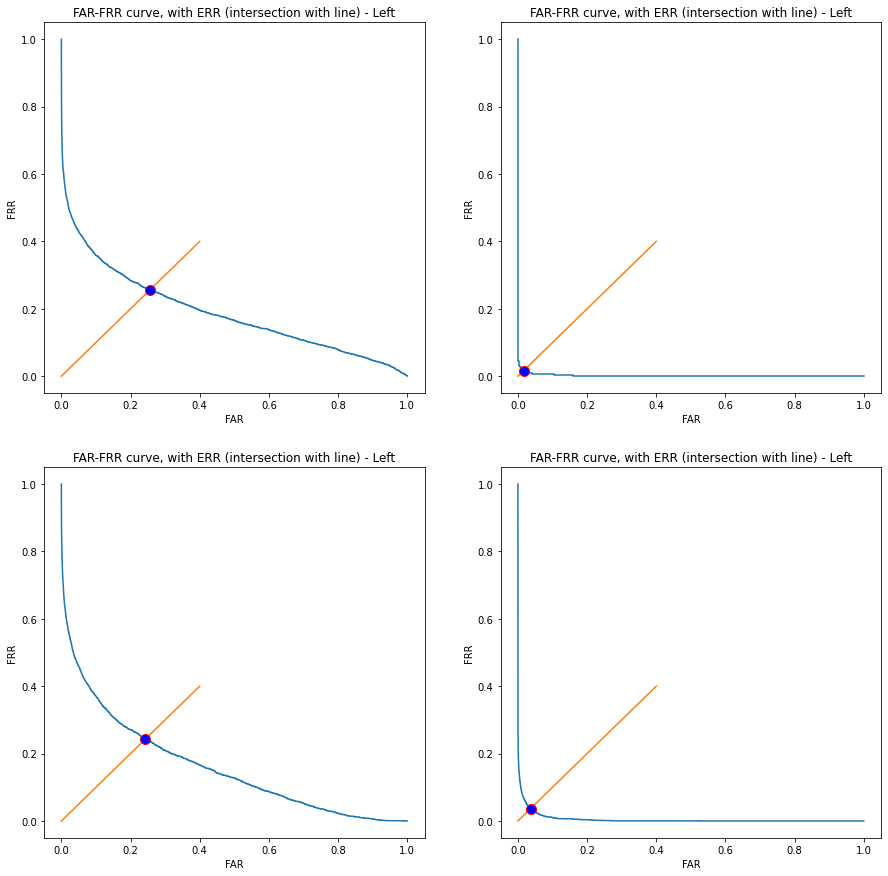

In [43]:
def plot_EER(fpr_list,tpr_list,row_EER_list,num_figure=4):
    fnr_list=[]
    for i in range(len(tpr_list)):
        fnr_list.append(1-tpr_list[i])

    fig, ax = plt.subplots(num_figure//2,num_figure//2, figsize=(15,15)) 
    
    for i, ax in enumerate(fig.axes):
        #plot the FAR-FRR curve :
        ax.plot(fpr_list[i],fnr_list[i])
        #Plot a diagonal line : indeed, everywhere on this line, FAR = FRR ! 
        ax.plot([0, 0.4], [0,0.4])
        ax.plot([row_EER_list[i]["fpr"]], [row_EER_list[i]["fnr"]], marker="o", markersize=10, markeredgecolor="red", markerfacecolor="blue")
        ax.title.set_text("FAR-FRR curve, with ERR (intersection with line) - Left")
        ax.set_xlabel('FAR')
        ax.set_ylabel('FRR')
        
EER = [EER_row_PCA,EER_row_LDA,EER_row_LBP,EER_row_DL]
plot_EER(fpr,tpr,EER)

#### Precision-Recall Curve and average precision

In [44]:
from sklearn.metrics import precision_recall_curve 

precision_PCA, recall_PCA, thresholds_PCA = precision_recall_curve(genuine_id_PCA, total_scores_PCA, pos_label=1)
precision_LDA, recall_LDA, thresholds_LDA = precision_recall_curve(genuine_id_LDA, total_scores_LDA, pos_label=1)
precision_LBP, recall_LBP, thresholds_LBP = precision_recall_curve(genuine_id_LBP, total_scores_LBP, pos_label=1)
precision_DL, recall_DL, thresholds_DL = precision_recall_curve(genuine_id_DL, total_scores_DL, pos_label=1)

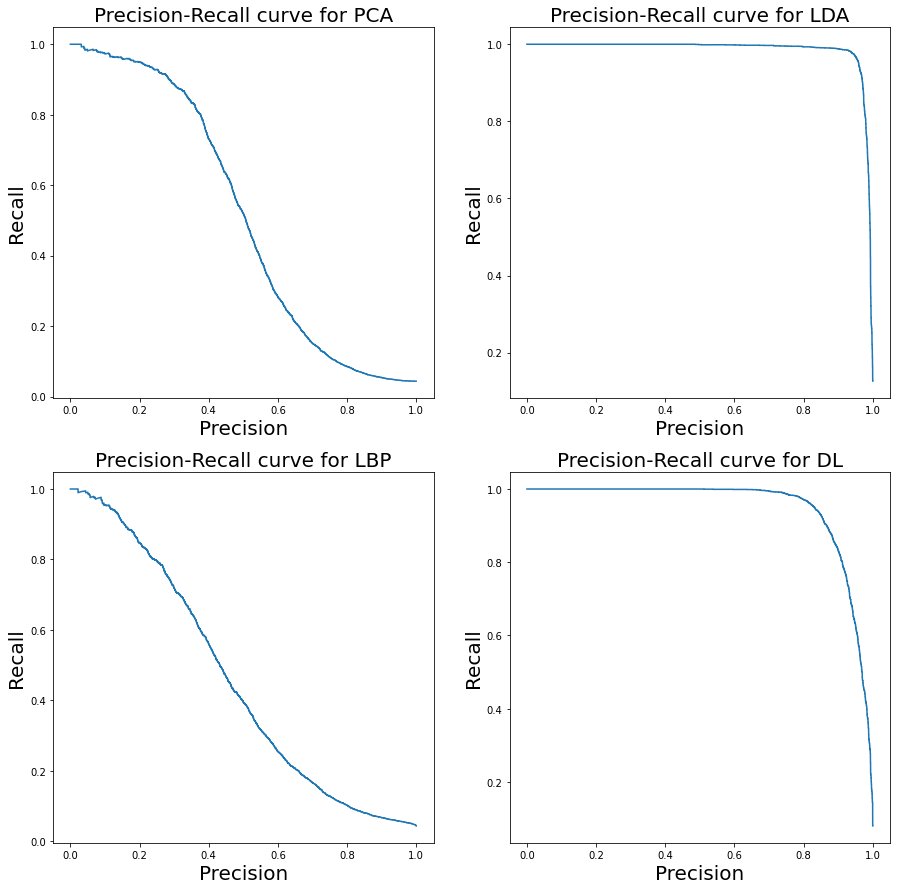

In [45]:
fig, ax = plt.subplots(2,2, figsize=(15,15)) 
bins = np.linspace(0, 1, 150)

method = ["PCA", "LDA", "LBP", "DL"]
recall = [recall_PCA,recall_LDA,recall_LBP,recall_DL]
precision = [precision_PCA,precision_LDA,precision_LBP,precision_DL]


for i, ax in enumerate(fig.axes):
    ax.plot(recall[i],precision[i]) 
    ax.set_title("Precision-Recall curve for " +method[i] , fontsize=20)
    ax.set_xlabel('Precision', fontsize=20)
    ax.set_ylabel('Recall', fontsize=20)

In [46]:
"""Calculate the Area Under the PR-curve."""
# metric.auc is a function to do it 

table = BeautifulTable()


PR_auc=[]
for i in range(len(method)):
    PR_auc.append(metrics.auc(recall[i],precision[i]))
    table.rows.append([PR_auc[i]])

table.rows.header = method
table.columns.header = ["PR AUC"]
print(table)

+-----+--------+
|     | PR AUC |
+-----+--------+
| PCA | 0.516  |
+-----+--------+
| LDA | 0.985  |
+-----+--------+
| LBP |  0.46  |
+-----+--------+
| DL  | 0.949  |
+-----+--------+


### 2. Validation as identification system

<div class="alert alert-block alert-success">
<b>Q5: </b> Validate the systems in an identification scenario. 
</div>

Hint: Generate a Cumulative Matching Curve. Calculate and compare rank-1 performance among the four feature extraction techniques.

For the equal error rate, we will use the **similarity matrix**. In this similarity matrix, the diagonal correspond to when we compare the same image. We will drop these values 



In [47]:
def drop_diag_from_df(dataframe):
    #replace diagonal value by Nan, and filter Nan values after to remove the diagonal
    array = np.array(dataframe)
    np.fill_diagonal(array, np.nan)
    array = array[~np.isnan(array)].reshape(array.shape[0], array.shape[1] - 1)
    df = pd.DataFrame(array)
    
    return df

In [48]:
sim_tb_PCA_2 = drop_diag_from_df(sim_tb_PCA)
sim_tb_LDA_2 = drop_diag_from_df(sim_tb_LDA)
sim_tb_LBP_2 = drop_diag_from_df(sim_tb_LBP)
sim_tb_DL_2 = drop_diag_from_df(sim_tb_DL)

In [49]:
sim_tb_PCA_2

,0,1,2,3,4,5,6,7,8,9,...,429,430,431,432,433,434,435,436,437,438
0,5.326238,6.824931,3.456548,3.675690,4.698031,6.268797,6.685367,5.864693,6.181352,5.024704,...,9.252982,7.660241,6.765265,6.110967,6.403124,5.895205,4.870635,6.252789,7.317506,6.402103
1,5.326238,6.259944,4.549099,4.821327,6.091789,6.010067,6.259768,4.615755,6.652761,4.428542,...,9.981748,6.913555,5.968180,5.942784,6.101233,6.851011,6.402850,5.859980,6.532118,5.410630
2,6.824931,6.259944,5.895513,7.515085,7.117609,6.422150,8.227854,5.550528,8.924827,7.402216,...,10.321280,7.504487,6.749868,7.505474,6.837020,8.717849,7.869358,7.460347,7.318959,7.016130
3,3.456548,4.549099,5.895513,4.594826,5.831501,6.097180,5.810513,5.452353,5.896161,4.694337,...,9.913512,6.940223,6.491314,5.902326,5.986334,6.106910,5.467141,5.985174,6.790817,5.839911
4,3.675690,4.821327,7.515085,4.594826,4.007751,6.104019,6.072960,5.364445,5.594937,4.103001,...,9.213569,7.766217,7.192743,6.651899,7.132792,6.296194,5.376810,6.369937,7.431544,6.459042
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
435,5.895205,6.851011,8.717849,6.106910,6.296194,6.312294,8.107491,8.159582,7.957477,7.908231,...,5.648167,9.413783,7.004446,6.471819,6.157692,5.399228,4.496307,6.201588,5.812129,5.768649
436,4.870635,6.402850,7.869358,5.467141,5.376810,5.764346,6.996561,7.093906,7.082731,6.399596,...,4.990043,9.434619,6.281820,5.812535,5.814753,5.000857,4.496307,5.203574,5.282635,4.766856
437,6.252789,5.859980,7.460347,5.985174,6.369937,6.594036,7.039194,7.595967,7.034032,7.554411,...,2.366400,10.837140,5.572733,3.690152,3.231191,3.267918,6.201588,5.203574,3.841222,4.066357
438,7.317506,6.532118,7.318959,6.790817,7.431544,7.202909,6.625299,8.354801,7.275380,8.208028,...,3.481758,10.987985,5.208572,4.497946,4.140039,3.687392,5.812129,5.282635,3.841222,4.428208


Note that we the row and the column number correspond to the image number. Based on that, we can retrieve the class by labels[i].

In [50]:
def recognition_rate(sim_matrix):
    #number of row
    matrix_length_ri = len(sim_matrix.index)
    #dataframe of recognized or not : if recognized, value = 1. Else, value = 0 
    #the columnn is for the rank : from 0 to 1
    #the row is for the particular subject_id
    #so, for example, if at row 1 and rank 1, the value is 1, it means that it has been recognized
    recognized_df_ri = pd.DataFrame()

    #first for loop to get through all row
    #second for loop to test for rank from 1 to 50

    for i in range(0,matrix_length_ri):
        #we sort the row "i", from lowest distance to higher
        sim_matrix_sorted = sim_matrix.iloc[i].to_frame().sort_values(
            by=list(sim_matrix.iloc[i].to_frame().columns),axis=0,ascending=True).transpose()
        #we save the subject id
        subject_id_ri = labels[sim_matrix_sorted.index[0]]
        #this list if for the "j" id with highest similarities 
        highest_similarities_id_ri  = []
        for j in range(1,440):
            highest_similarities_id_ri.append(labels[sim_matrix_sorted.columns[j-1]])
            #if the subject id is in the list, we set the value of the corresponding dataframe cell to 1
            if subject_id_ri in highest_similarities_id_ri:
                recognized_df_ri.at[i,j] =  1
            else:
                recognized_df_ri.at[i,j] =  0

    #we can now sum over all rows (subject_id)
    #by dividing by matrix_length, we should get the recognition rate
    recognition_rate_ri = recognized_df_ri.sum(axis=0)/matrix_length_ri
    
    return recognition_rate_ri


In [51]:
reco_rate_PCA = recognition_rate(sim_tb_PCA_2)
reco_rate_LDA = recognition_rate(sim_tb_LDA_2)
reco_rate_LBP = recognition_rate(sim_tb_LBP_2)
reco_rate_DL = recognition_rate(sim_tb_DL_2)

In [52]:
print(reco_rate_PCA)

1      0.918182
2      0.938636
3      0.938636
4      0.947727
5      0.950000
         ...   
435    1.000000
436    1.000000
437    1.000000
438    1.000000
439    1.000000
Length: 439, dtype: float64


Text(0, 0.5, 'Recognition Rate')

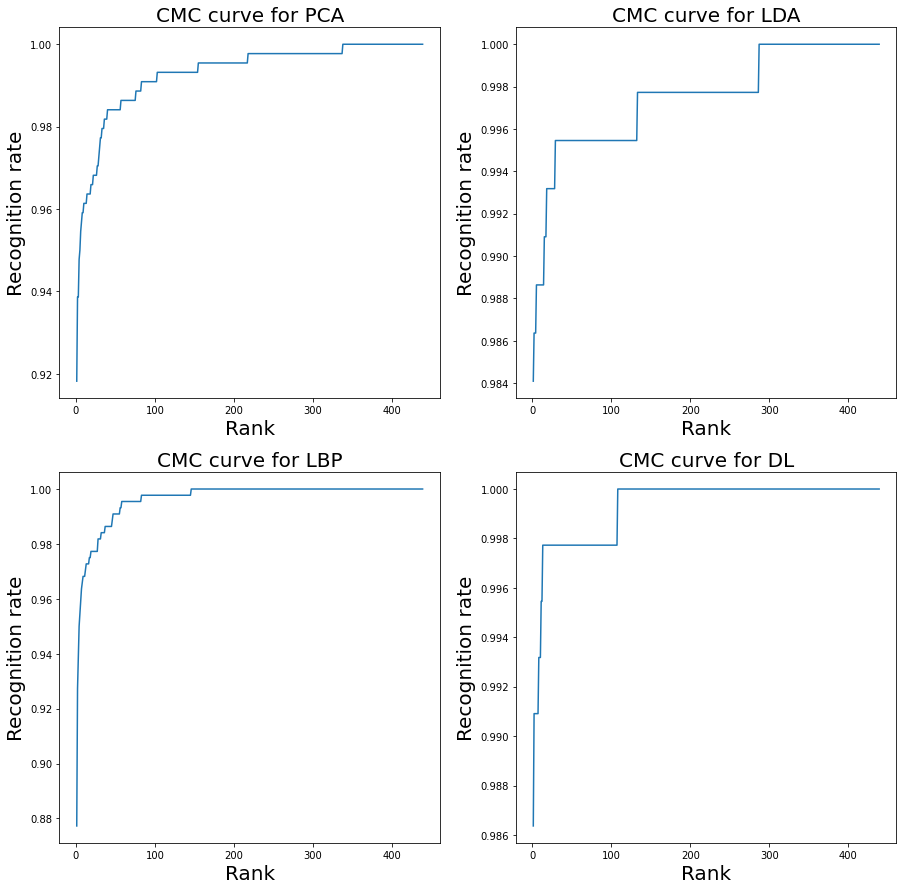

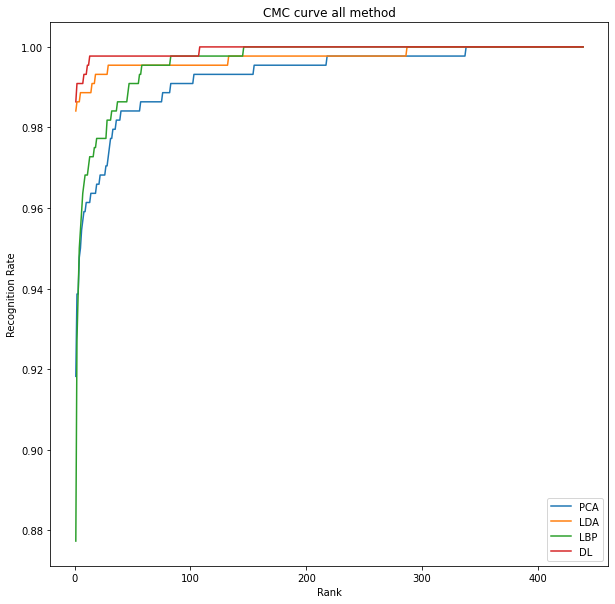

In [53]:
fig, ax = plt.subplots(2,2, figsize=(15,15)) 
bins = np.linspace(0, 1, 150)

method = ["PCA", "LDA", "LBP", "DL"]
reco_rates = [reco_rate_PCA,reco_rate_LDA,reco_rate_LBP,reco_rate_DL]


for i, ax in enumerate(fig.axes):
    ax.plot(reco_rates[i]) 
    ax.set_title("CMC curve for " +method[i] , fontsize=20)
    ax.set_xlabel('Rank', fontsize=20)
    ax.set_ylabel('Recognition rate', fontsize=20)

fig, axis = plt.subplots(1,1,figsize=(10,10))
axis.plot(reco_rate_PCA, label='PCA')
axis.plot(reco_rate_LDA, label='LDA')
axis.plot(reco_rate_LBP, label='LBP')
axis.plot(reco_rate_DL, label='DL')
axis.title.set_text("CMC curve all method") 
axis.legend()
axis.set_xlabel('Rank')
axis.set_ylabel('Recognition Rate')


## VI. Tasks
All tasks should be accompanied by a text providing information on the technique, steps, and the reasoning behind choosing the techniques.


### 1. Mandatory tasks
<b>The student should do all of the tasks indicated below</b>: 
1. Execute all the tasks indicated in the document above
2. Compare the 4 feature representations (LBP, PCA, LDA, DL using Siamese Networks) using the implemented validation metrics in Questions 2-5, and report on the performance. Please make it clear where in your report the comparison is made for each question. 

### 2. Tasks of choice
<b>The student should choose a number of tasks equivalent to <u>at least 3pts</u> from the list below (pts are not related to the grades)</b>. 

1. Evaluate your system on the other two datasets (AT&T, LFW). Feel free to subsample datasets if they are too memory-consuming on your system. (1pt.)
2. Implement 2 different face detectors and compare all techniques to the ground truth bounding boxes provided in <em>CalTechFacesDirs/ImageData.mat</em>. Look up the literature for methods to compare different face detectors. (1pt.)
3. Implement a classification-based scoring method, using an advanced classifier of your choice. Evaluate this system in an identification and verification scenario. (Hint: Follow steps introduced in section IV. Distance-based and classification-based scoring) (2pt.)
4. Experiment with the Siamese deep learning model by implementing a different loss function or a different distance calculation layer. (1pt.)
5. Pre-train your deep learning network on a different (larger) dataset and then fine-tune it with CALTECH and compare the results. (2pt.) 
6. Implement a different deep learning model* (2pt.)


e.g. performing task 4 and 5 is valid because their points sum up to 3. 

<em>Note: Indicate clearly which tasks you end up choosing and where we can find the implementations and/or results. </em>

[*] The implemented network has to be significantly different, adding some layers like batch normalisation, dropout, ... to the current network or increasing the kernel size, amount of filters and activation functions does not count.

### Detection faces

Inspired by implementation of [link](https://machinelearningmastery.com/how-to-develop-a-face-recognition-system-using-facenet-in-keras-and-an-svm-classifier/)

Selet output as being (160,160,3) to make it easy to use facenet ! We will start from the original dataset, with images of size 896x592 pixels. Remember the shapes : 

Let's build a dataframe from this dataset to make it easy to work

Let's work with **RGB images** instead of gray scale. We will have 3 channels instead of 1. The advantage will be that later on, when developping the deep learning technique, we will also give the color information to the network. The disadvantage is that it becomes computationally costly (run on GPU if you can).

In [281]:
def read_img_RGB(imagePath):
    # load the image and convert it to grayscale
    img = cv2.imread(str(imagePath))
    rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # ROI, and resize it to a canonical size
    imagePathStem = str(imagePath.stem)
    k = int(imagePathStem[imagePathStem.rfind("_") + 1:][:4]) - 1
    

    return rgb_img, imagePath.parent.name

In [282]:
# grab in all the subdirs all the image paths associated with the faces
datasetPath = Path("CalTechFacesDirs")
imagePaths = datasetPath.glob("*/*.jpg")

# read image and label information
imgs = [read_img_RGB(imagePath) for imagePath in imagePaths]
data = pd.DataFrame(imgs, columns =['images', 'target'])


# check if all images were found successfully 
# Please note that 5 images were removed from the original set, because 
# they wouldn't match the corresponding individual.
assert len(data['images']) == len(data['target']) == 445



In [270]:
data

,images,target
0,"[[[65, 75, 82], [52, 63, 67], [65, 74, 77], [5...",person_001
1,"[[[18, 7, 0], [18, 5, 0], [21, 0, 0], [31, 2, ...",person_001
2,"[[[229, 220, 216], [227, 218, 214], [226, 217,...",person_001
3,"[[[138, 175, 197], [153, 190, 212], [142, 177,...",person_001
4,"[[[87, 106, 97], [90, 109, 100], [85, 104, 95]...",person_001
...,...,...
440,"[[[24, 24, 36], [24, 26, 36], [41, 43, 53], [7...",person_026
441,"[[[129, 162, 171], [123, 156, 165], [126, 158,...",person_026
442,"[[[69, 86, 83], [61, 80, 77], [63, 83, 78], [5...",person_026
443,"[[[117, 136, 139], [113, 132, 135], [116, 135,...",person_026


In [256]:
print("the whole dataframe has as shape",data.shape)
print("the image column has as shape", data["images"].iloc[0].shape)

the whole dataframe has as shape (445, 2)
the image column has as shape (592, 896, 3)


plot some image

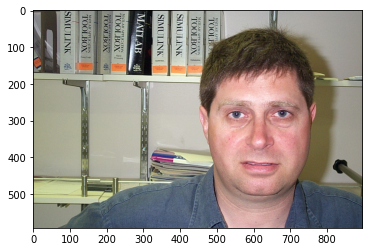

In [284]:
plt.imshow(data["images"][0])

In [ ]:
%%capture
!pip install mtcnn
from mtcnn.mtcnn import MTCNN

In [259]:
print(data["images"][0].shape)

(592, 896, 3)


(592, 896, 3)
(160, 160, 3)


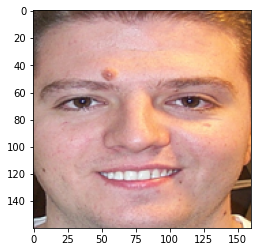

In [296]:
from PIL import Image
from numpy import asarray
from mtcnn.mtcnn import MTCNN
import logging
import tensorflow 
tensorflow.get_logger().setLevel(logging.ERROR)

train = data["images"]
"""
for some samples, we are not able to detect the face
so, the results dic is empty
when looking for face = pixels[y1:y2, x1:x2], it gives
an error
what we can do is to remove theses images without faces from the training set
and for the test set, what we can do is to "copy" the samples dic of the previous
samples : it will be an error but at least not make the code bug

"""
# extract a single face from a given photograph
def extract_face(dataset, required_size=(160, 160)):
    images = np.array(dataset)
    images = Image.fromarray(images, "RGB") 
    # convert to array
#     print(images.getbands())
    pixels = asarray(images)
    # create the detector, using default weights
    detector = MTCNN()
    # detect faces in the image
    results = detector.detect_faces(pixels)
#     print(results)
    # extract the bounding box from the first face
    x1, y1, width, height = results[0]['box']
    # bug fix
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    # extract the face
    face = pixels[y1:y2, x1:x2]
    # resize pixels to the model size
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = asarray(image)
    return face_array

# load the photo and extract the face
print(train.iloc[52].shape)
face = extract_face(train[52])
print(face.shape)
plt.imshow(face)

In [301]:
print(face.shape)

(160, 160, 3)


In [309]:
# load images and extract faces for all images in a directory
def load_faces(dataframe):
    faces = list()
    # enumerate files
    for i in range (0,len(dataframe)):
        face = extract_face(dataframe["images"][i])
        faces.append(face)
    return faces

In [310]:
def create_dataset(dataframe):
    X = list()
    y = list()
    faces = load_faces(dataframe)
    X.extend(faces)
    y.extend(dataframe["target"])
    return asarray(X), asarray(y) 

Detecting face with **mtcnn** takes times (around 1s per image on my machine). Let's create a function that save the detected images, so the other times we can just load it.

In [318]:
def detect_with_mtcnn(data,existing=1):
    if existing == 0:
        # create dataset by detecting the face 
        dataX, datay = create_dataset(data)
        np.savez_compressed('face_detection/mtcnn_dataset.npz', dataX, datay)
    elif existing == 1:
        data = np.load('face_detection/mtcnn_dataset.npz',allow_pickle=True)
        dataX, datay = data['arr_0'], data['arr_1']
    
    
    return dataX,datay

In [319]:
dataX,datay = detect_with_mtcnn(data,existing=1)

### Implement a different deep learning model* (2pt.)

In this part of the notebook, we will try to use FaceNet to create an embedding of the image. We will use a pretrained version of FaceNet on the MS-Celeb-1M dataset, by Hiroki Tanai. The [GitHub](https://github.com/nyoki-mtl/keras-facenet) page of his project is available, where the pretrained model that we will use is available at [drive](https://drive.google.com/drive/folders/1pwQ3H4aJ8a6yyJHZkTwtjcL4wYWQb7bn) containing the model and the weights. 

However, note that Hiroki used a model  with input images of size 160x160, while our images are only 47x47. So, we will need to change the input layer of the model. To still use some of its pretrained weights, we will need to do some triks insipered by this [forum](https://stackoverflow.com/questions/49546922/keras-replacing-input-layer).

We will use the pretrained model, and not fine tune it, because the model has been trained on a dataset of 1 000 000 images. With our dataset of only 80 images, it will be very difficult to improve it. In the "experiment" part of this notebook, we have still tried to train it, but had worse result than the pretrained model.

We will input the images where the faces have been detected thanks to the previous method, and the FaceNet model will output an embedding (i.e. a feature vector) of this image that we will then classify using SVM or other classifiers.

This model has already been trained on a face dataset. So we can simply use it to predict the embedding of the images where we have detected the faces !



In [54]:
%%capture
!pip install gdown
!pip install --upgrade gdown

In [56]:
%%capture

import gdown
url = "https://drive.google.com/file/d/1PZ_6Zsy1Vb0s0JmjEmVd8FS99zoMCiN1/view?usp=sharing"
gdown.download(url=url, output='facenet_keras.h5', quiet=False, fuzzy=True)

In [106]:
model = load_model("facenet_keras.h5")

In [107]:
model_config = model.get_config()


In [108]:
model.summary()

Model: "inception_resnet_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv2d_1a_3x3 (Conv2D)          (None, 79, 79, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
Conv2d_1a_3x3_BatchNorm (BatchN (None, 79, 79, 32)   96          Conv2d_1a_3x3[0][0]              
__________________________________________________________________________________________________
Conv2d_1a_3x3_Activation (Activ (None, 79, 79, 32)   0           Conv2d_1a_3x3_BatchNorm[0][0]    
________________________________________________________________________________

In [122]:
input_layer_name = model_config['layers'][0]['name']
model_config['layers'][0] = {
                      'name': 'new_input',
                      'class_name': 'InputLayer',
                      'config': {
                          'batch_input_shape': (None, 160, 160,1),
                          'dtype': 'float32',
                          'sparse': False,
                          'name': 'new_input'
                      },
                      'inbound_nodes': []
                  }
model_config['layers'][1]['inbound_nodes'] = [[['new_input', 0, 0, {}]]]
model_config['input_layers'] = [['new_input', 0, 0]]

In [123]:
new_model = model.__class__.from_config(model_config, custom_objects={})  # change custom objects if necessary

In [110]:
# iterate over all the layers that we want to get weights from
weights = [layer.get_weights() for layer in model.layers[1:]]
for layer, weight in zip(new_model.layers[1:], weights):
    layer.set_weights(weight)

NameError: name 'new_model' is not defined

In [73]:
# extract number of samples and image dimensions (for later display)
n_samples, h, w, n_channels = faces.images.shape
imshape = (h, w, n_channels)

# count number of individuals
n_classes = faces.target.max() +1

n_features = faces.data.shape[1]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_classes: %d" % n_classes)
print("n_features: %d" % n_features)

Total dataset size:
n_samples: 440
n_classes: 26
n_features: 2209


In [79]:
print(faces['images'].shape)

(440, 47, 47, 1)


In [96]:
X_train = faces['images']

In [100]:
model = load_model("facenet_keras.h5")

In [101]:
model.summary()


Model: "inception_resnet_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv2d_1a_3x3 (Conv2D)          (None, 79, 79, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
Conv2d_1a_3x3_BatchNorm (BatchN (None, 79, 79, 32)   96          Conv2d_1a_3x3[0][0]              
__________________________________________________________________________________________________
Conv2d_1a_3x3_Activation (Activ (None, 79, 79, 32)   0           Conv2d_1a_3x3_BatchNorm[0][0]    
________________________________________________________________________________

In [104]:
model._layers.pop(0)


In [105]:
model.summary()


Model: "inception_resnet_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Conv2d_1a_3x3 (Conv2D)          (None, 79, 79, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
Conv2d_1a_3x3_BatchNorm (BatchN (None, 79, 79, 32)   96          Conv2d_1a_3x3[0][0]              
__________________________________________________________________________________________________
Conv2d_1a_3x3_Activation (Activ (None, 79, 79, 32)   0           Conv2d_1a_3x3_BatchNorm[0][0]    
__________________________________________________________________________________________________
Conv2d_2a_3x3 (Conv2D)          (None, 77, 77, 32)   9216        Conv2d_1a_3x3_Activation[0][0]   
________________________________________________________________________________

In [94]:
from tensorflow.keras.models import load_model
from sklearn.preprocessing import Normalizer


class createFaceNet():
    def __init__(self):
        ''' init the class'''
        #load the model 
        self.embedder = load_model('facenet_keras.h5')
        #define a normalization for the feature vector 
        self.norm = Normalizer(norm='l2')
    def __call__(self, X):
        return self.transform(X)
        # Corners of the eye in input image
    def get_embedding(self, face_pixels):
        # scale pixel values
        face_pixels = face_pixels.astype('float32')
        # standardize pixel values across channels (global)
        mean, std = face_pixels.mean(), face_pixels.std()
        face_pixels = (face_pixels - mean) / (std+0.0001)
        # transform face into one sample
        samples = np.expand_dims(face_pixels, axis=0)
        # make prediction to get embedding
        yhat = self.embedder.predict(samples)
        return yhat[0] 
            
    def transform(self, X):
        emb = []
        for img in X:
            emb.append(self.get_embedding(img))
        print("Embedding of the images generated")
        return np.array(emb)

In [97]:
feature_extractor = createFaceNet()
#resize image to the input of FaceNet
resized_X_train =np.array(tf.image.resize(X_train, (47, 47)))

#extract embedding from images
facenet_train  = feature_extractor(resized_X_train)
print(f'The computed features have size: {facenet_train.shape}')

ValueError: in user code:

    C:\Users\deniz\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\keras\engine\training.py:1478 predict_function  *
        return step_function(self, iterator)
    C:\Users\deniz\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\keras\engine\training.py:1468 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\deniz\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\deniz\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\deniz\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\deniz\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\keras\engine\training.py:1461 run_step  **
        outputs = model.predict_step(data)
    C:\Users\deniz\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\keras\engine\training.py:1434 predict_step
        return self(x, training=False)
    C:\Users\deniz\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    C:\Users\deniz\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:274 assert_input_compatibility
        ', found shape=' + display_shape(x.shape))

    ValueError: Input 0 is incompatible with layer inception_resnet_v1: expected shape=(None, 160, 160, 3), found shape=(None, 47, 47, 1)
